#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


## Lab. 06 - Reinforcement Learning

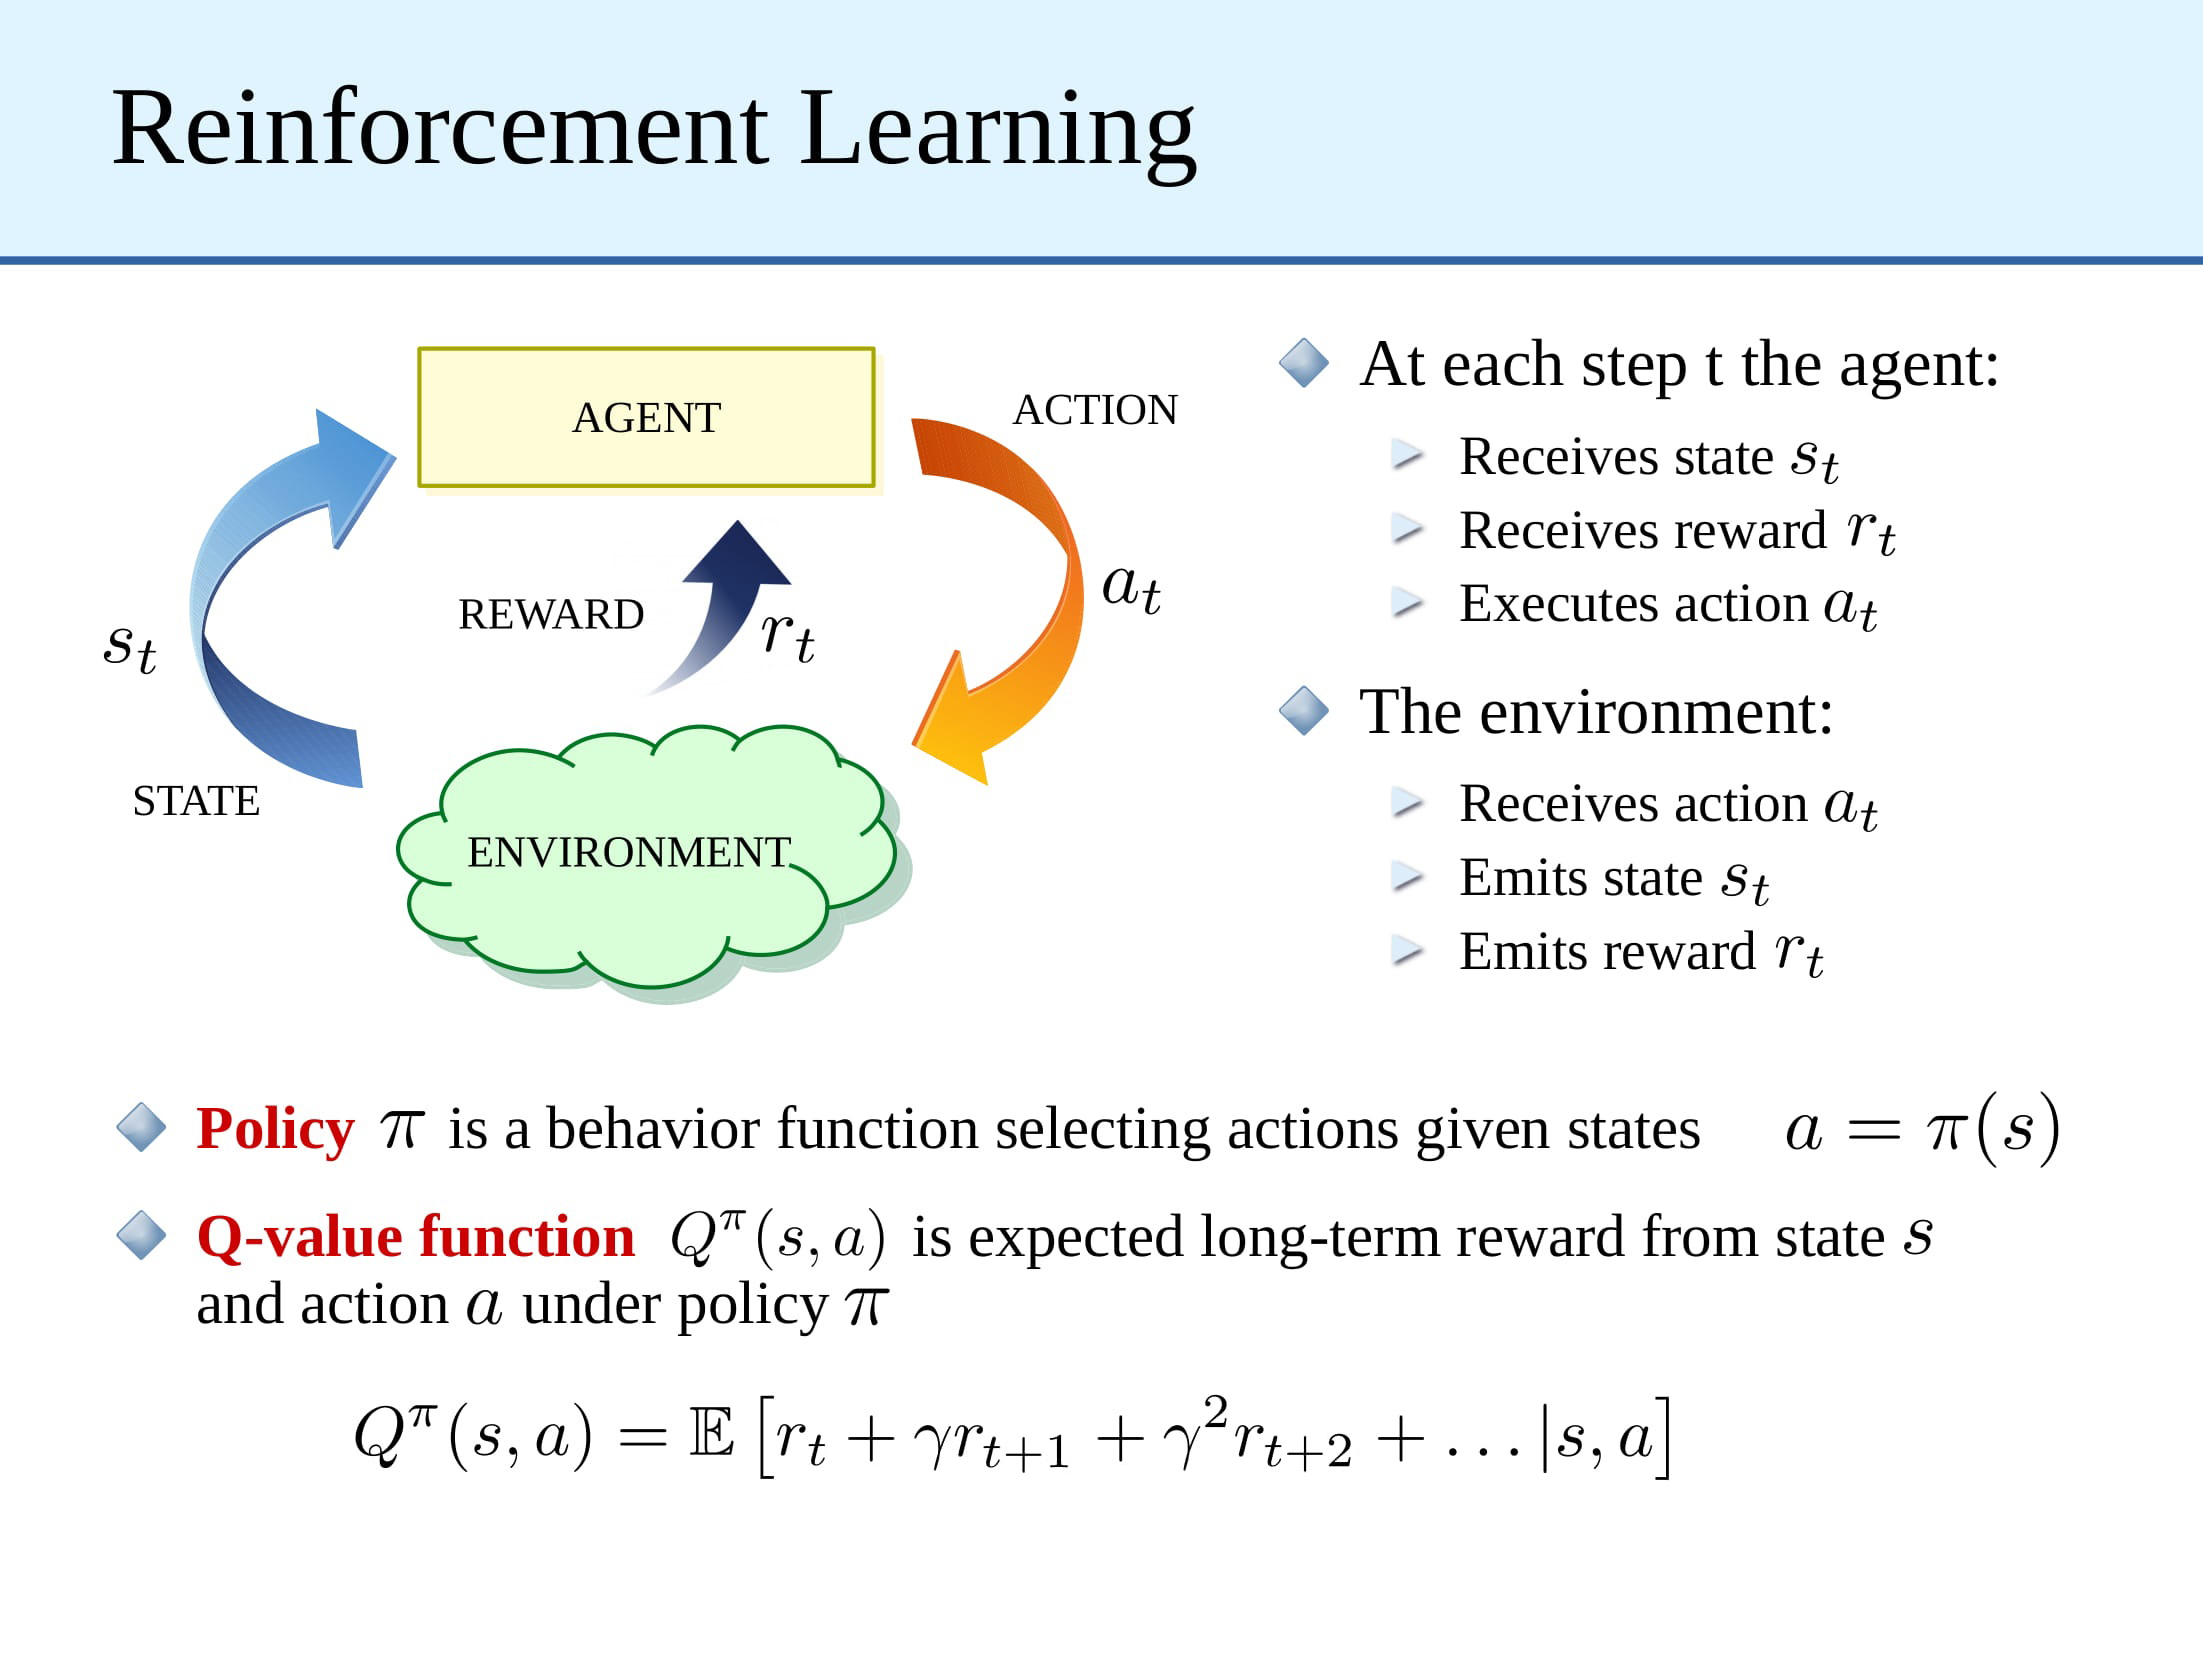

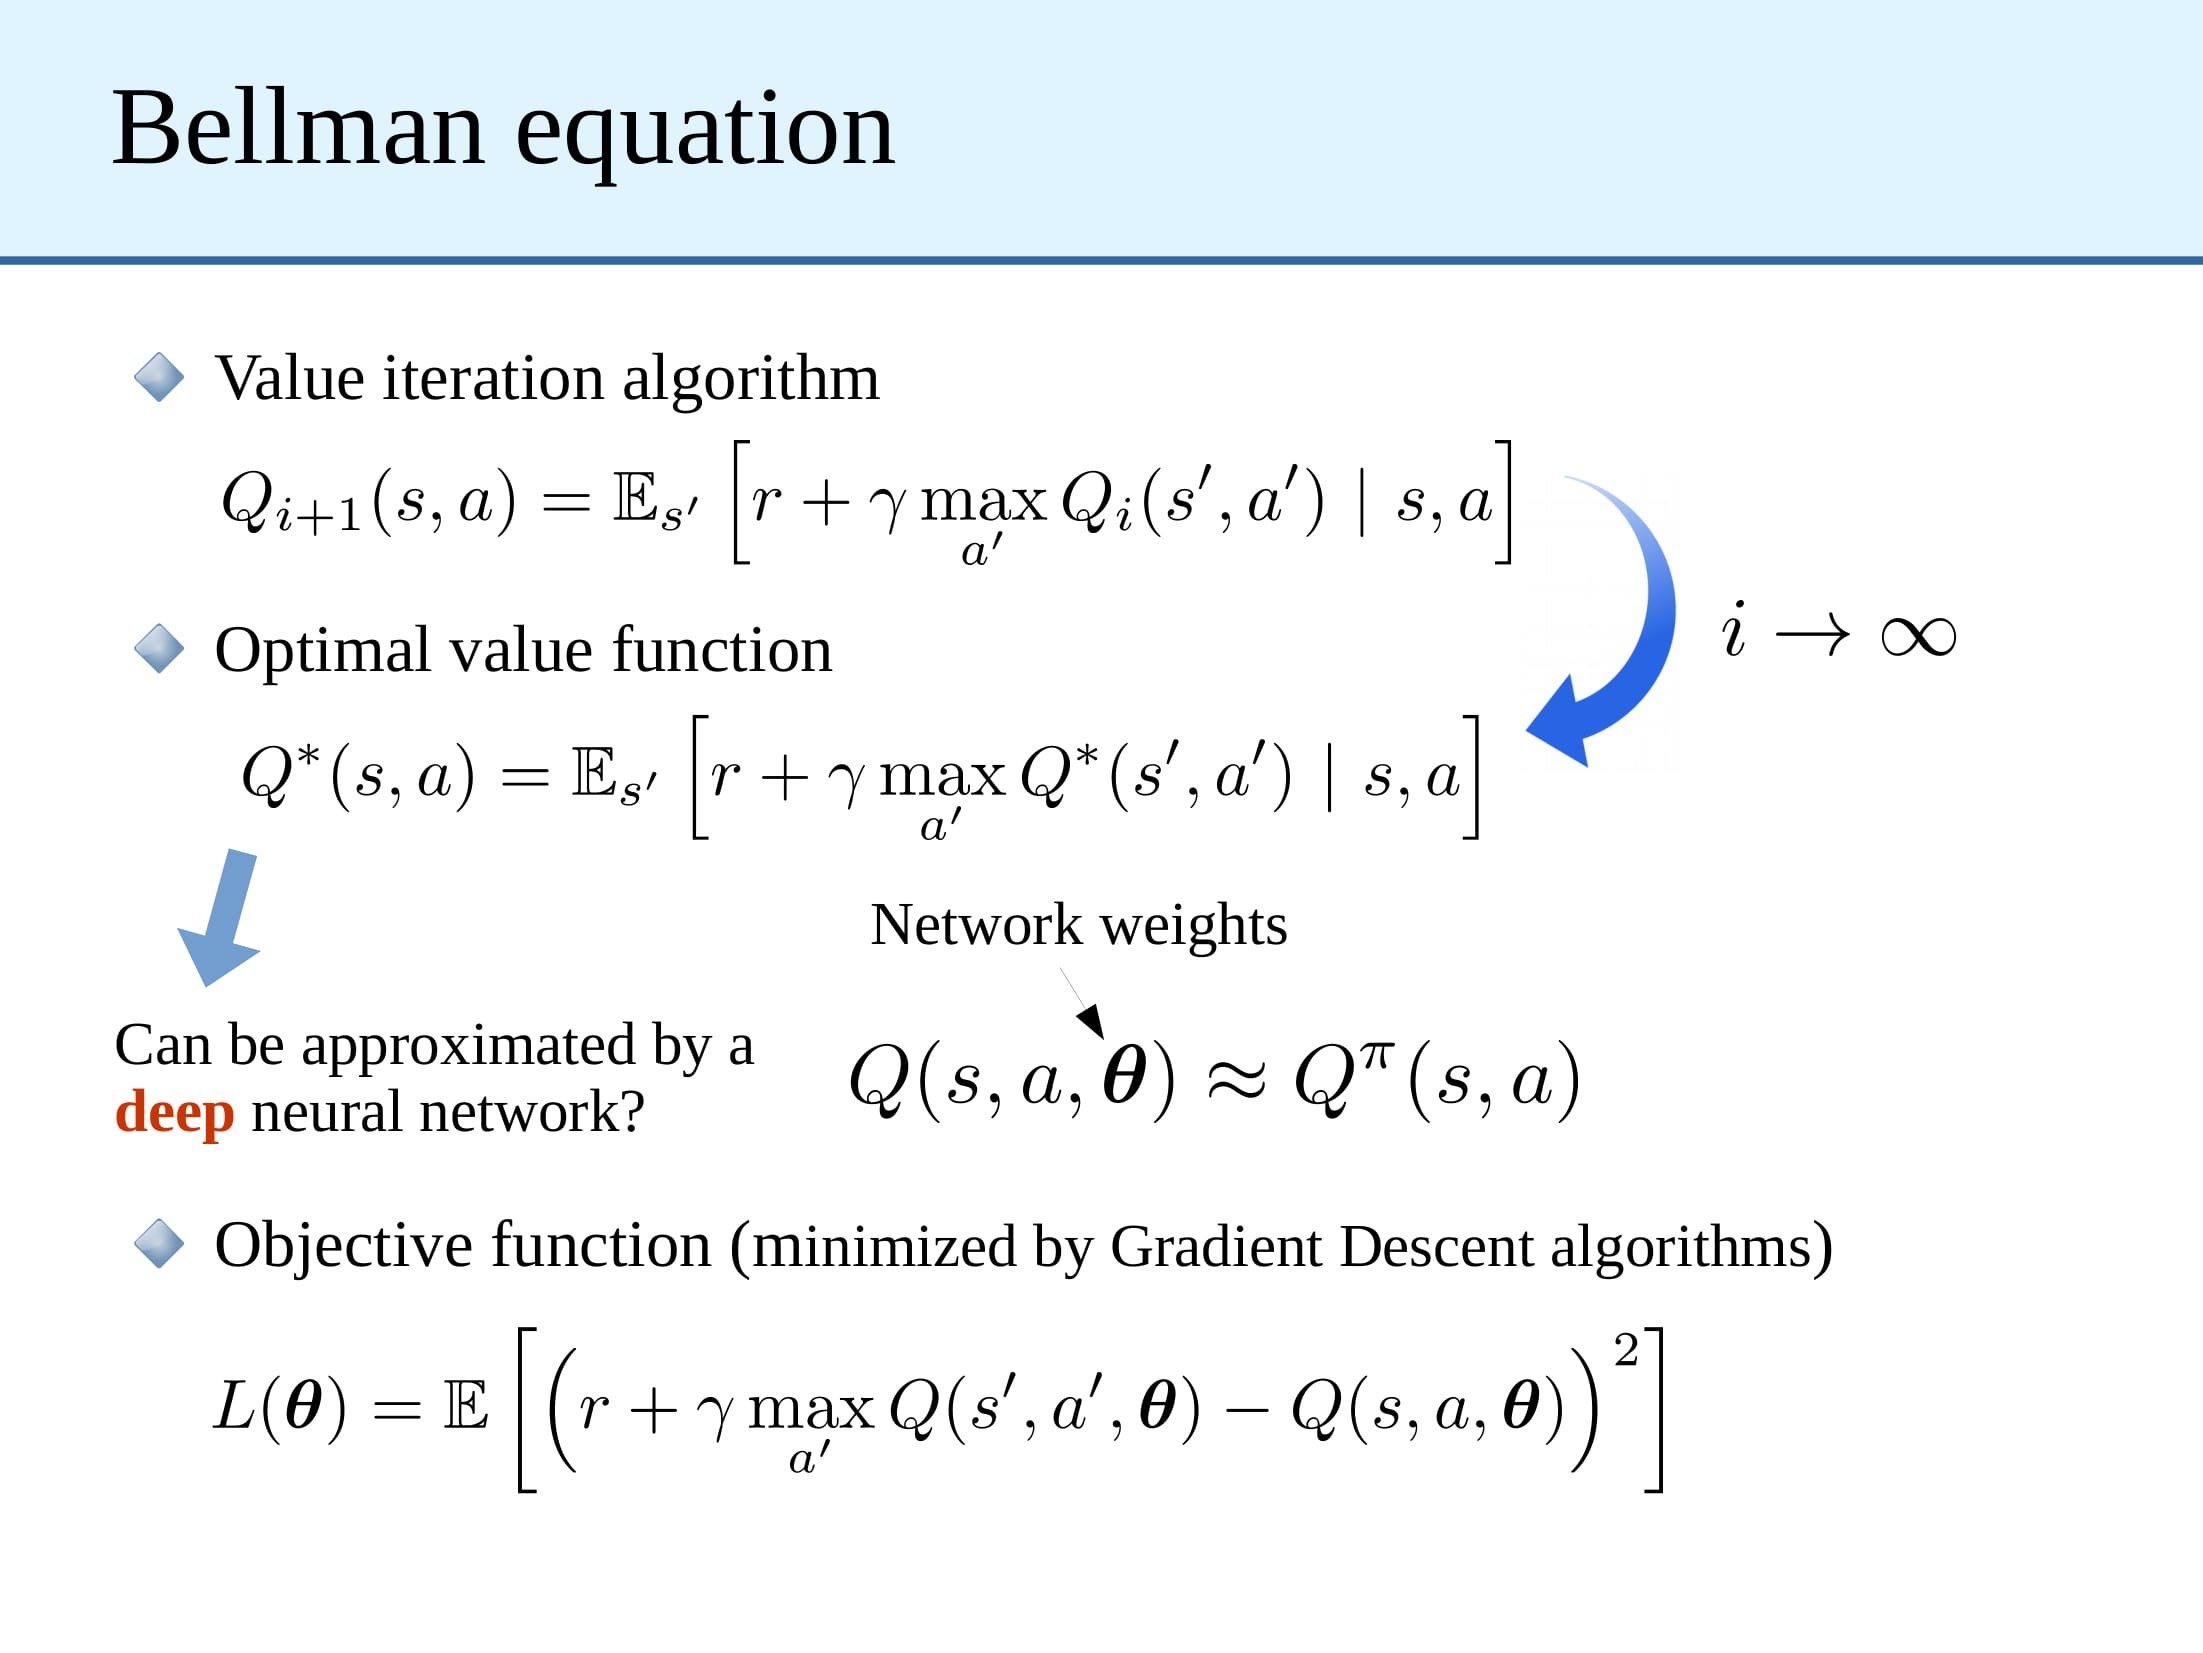

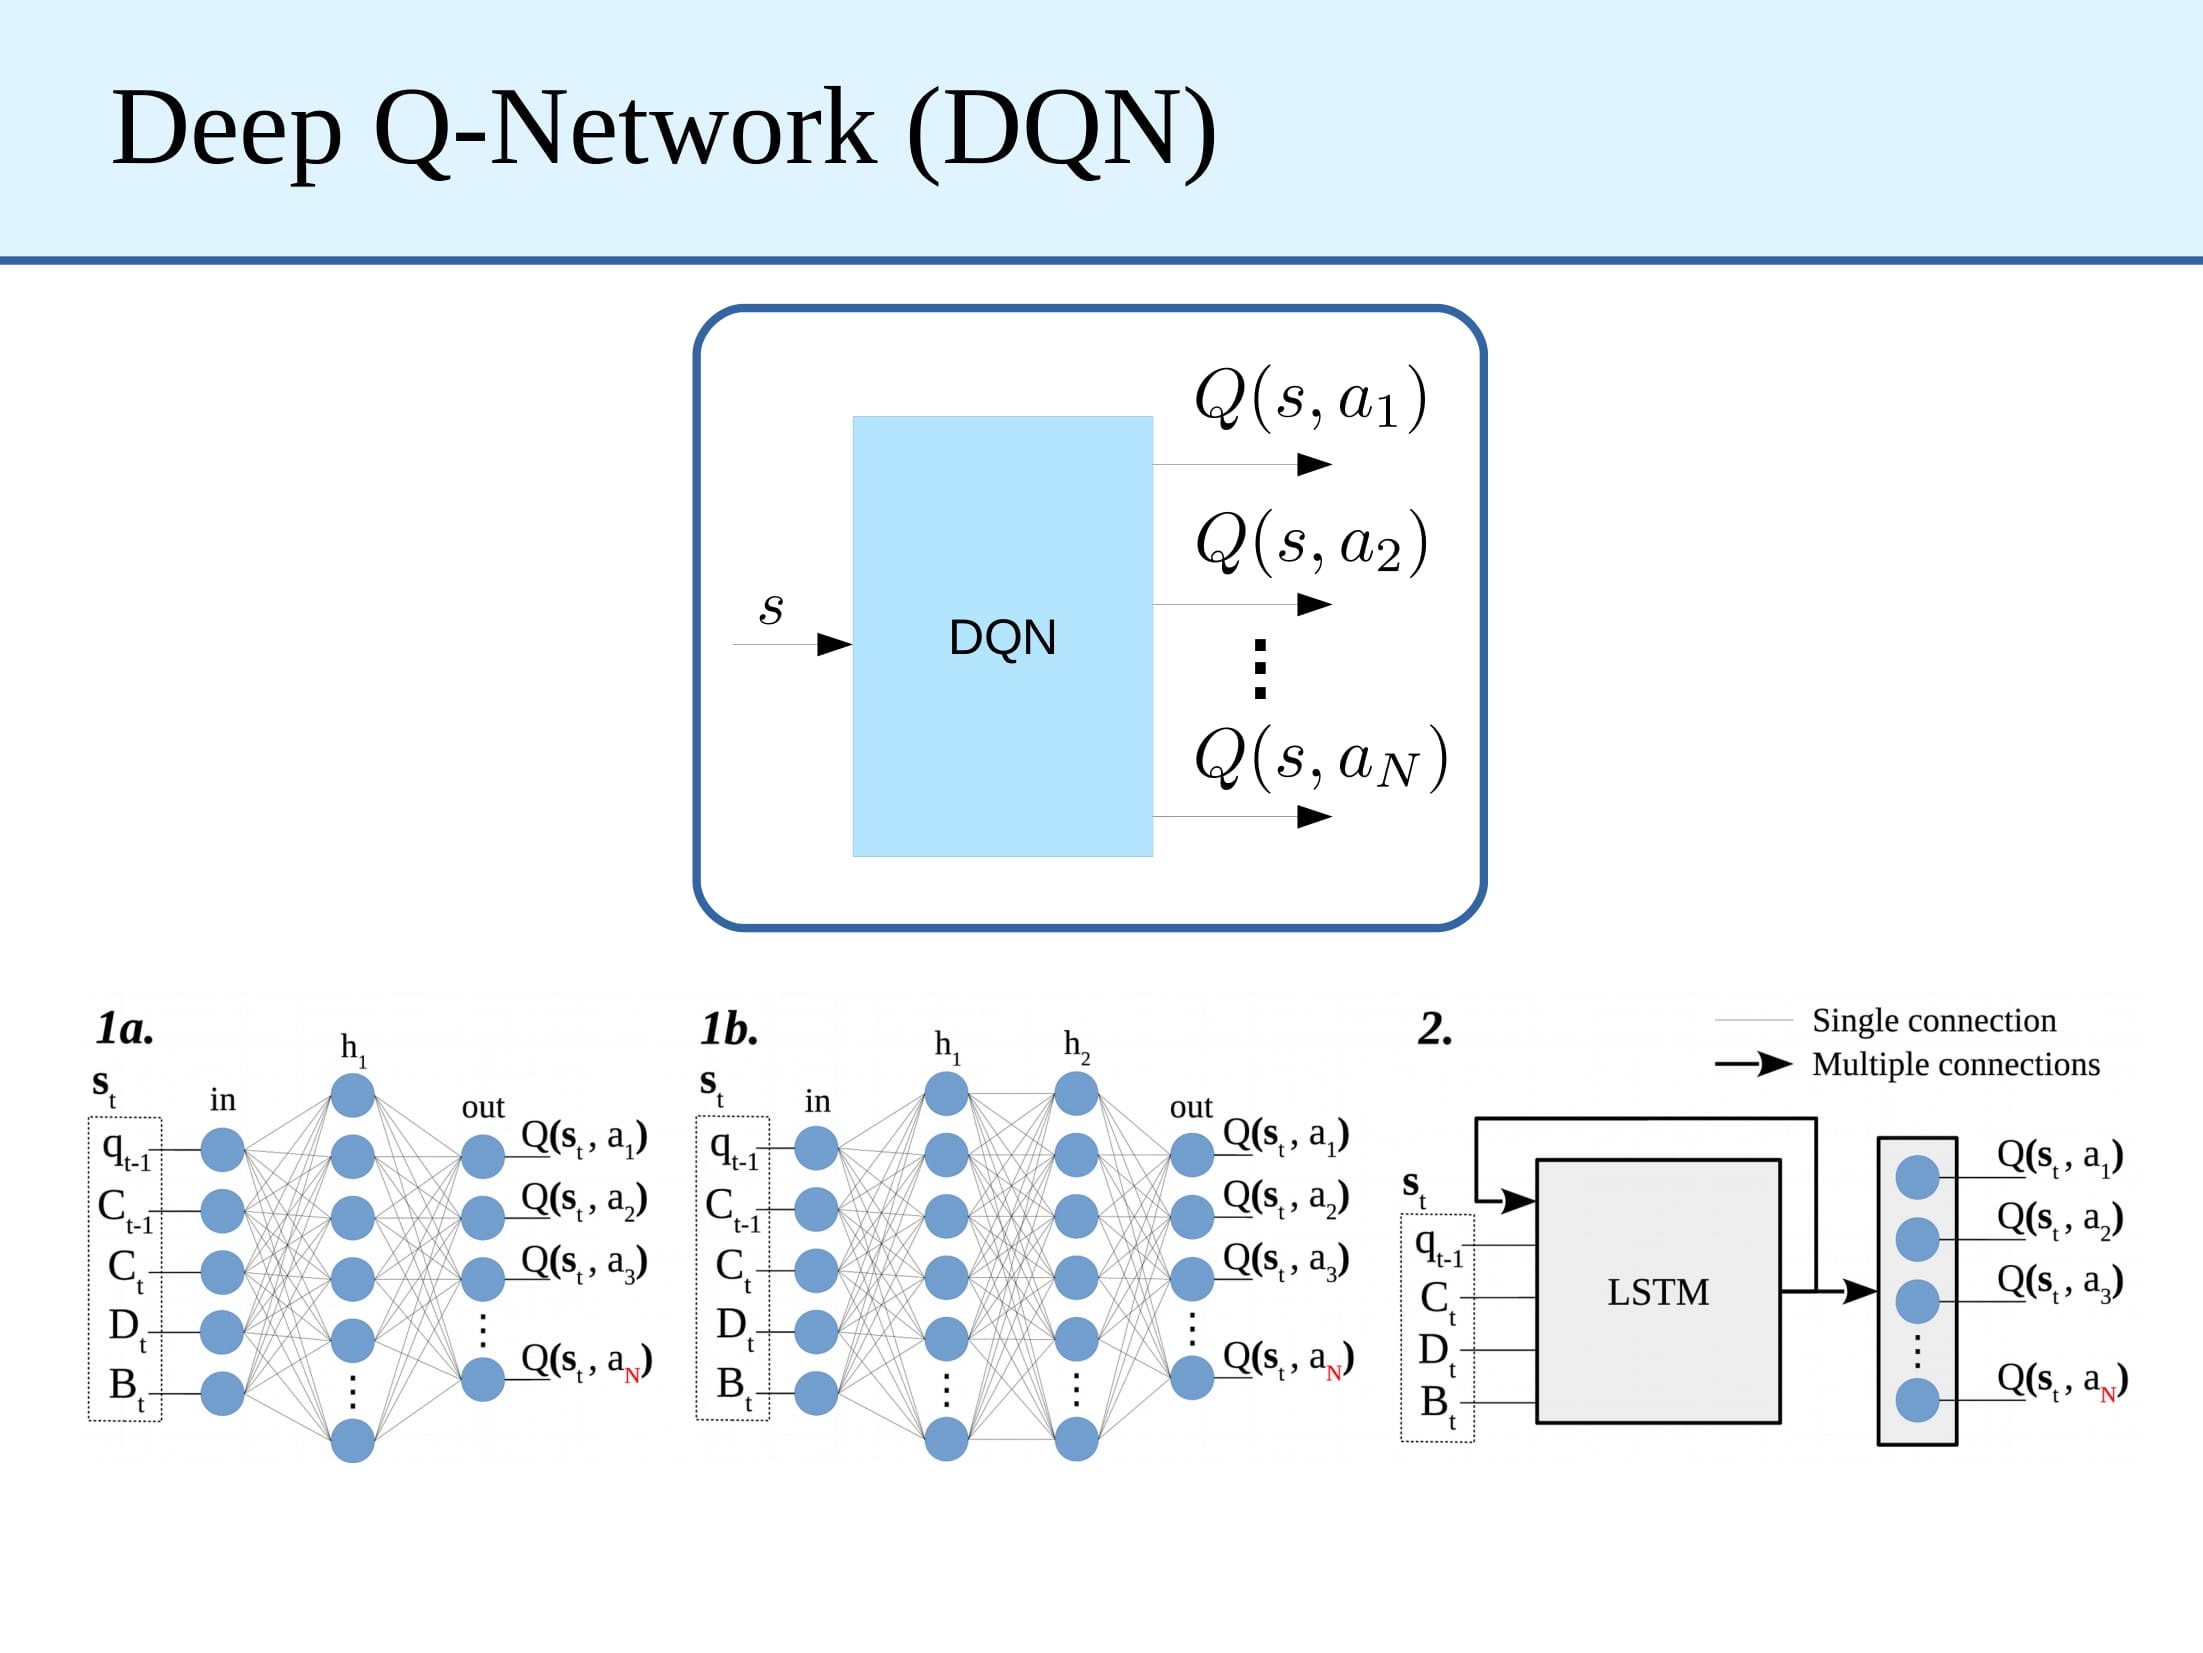

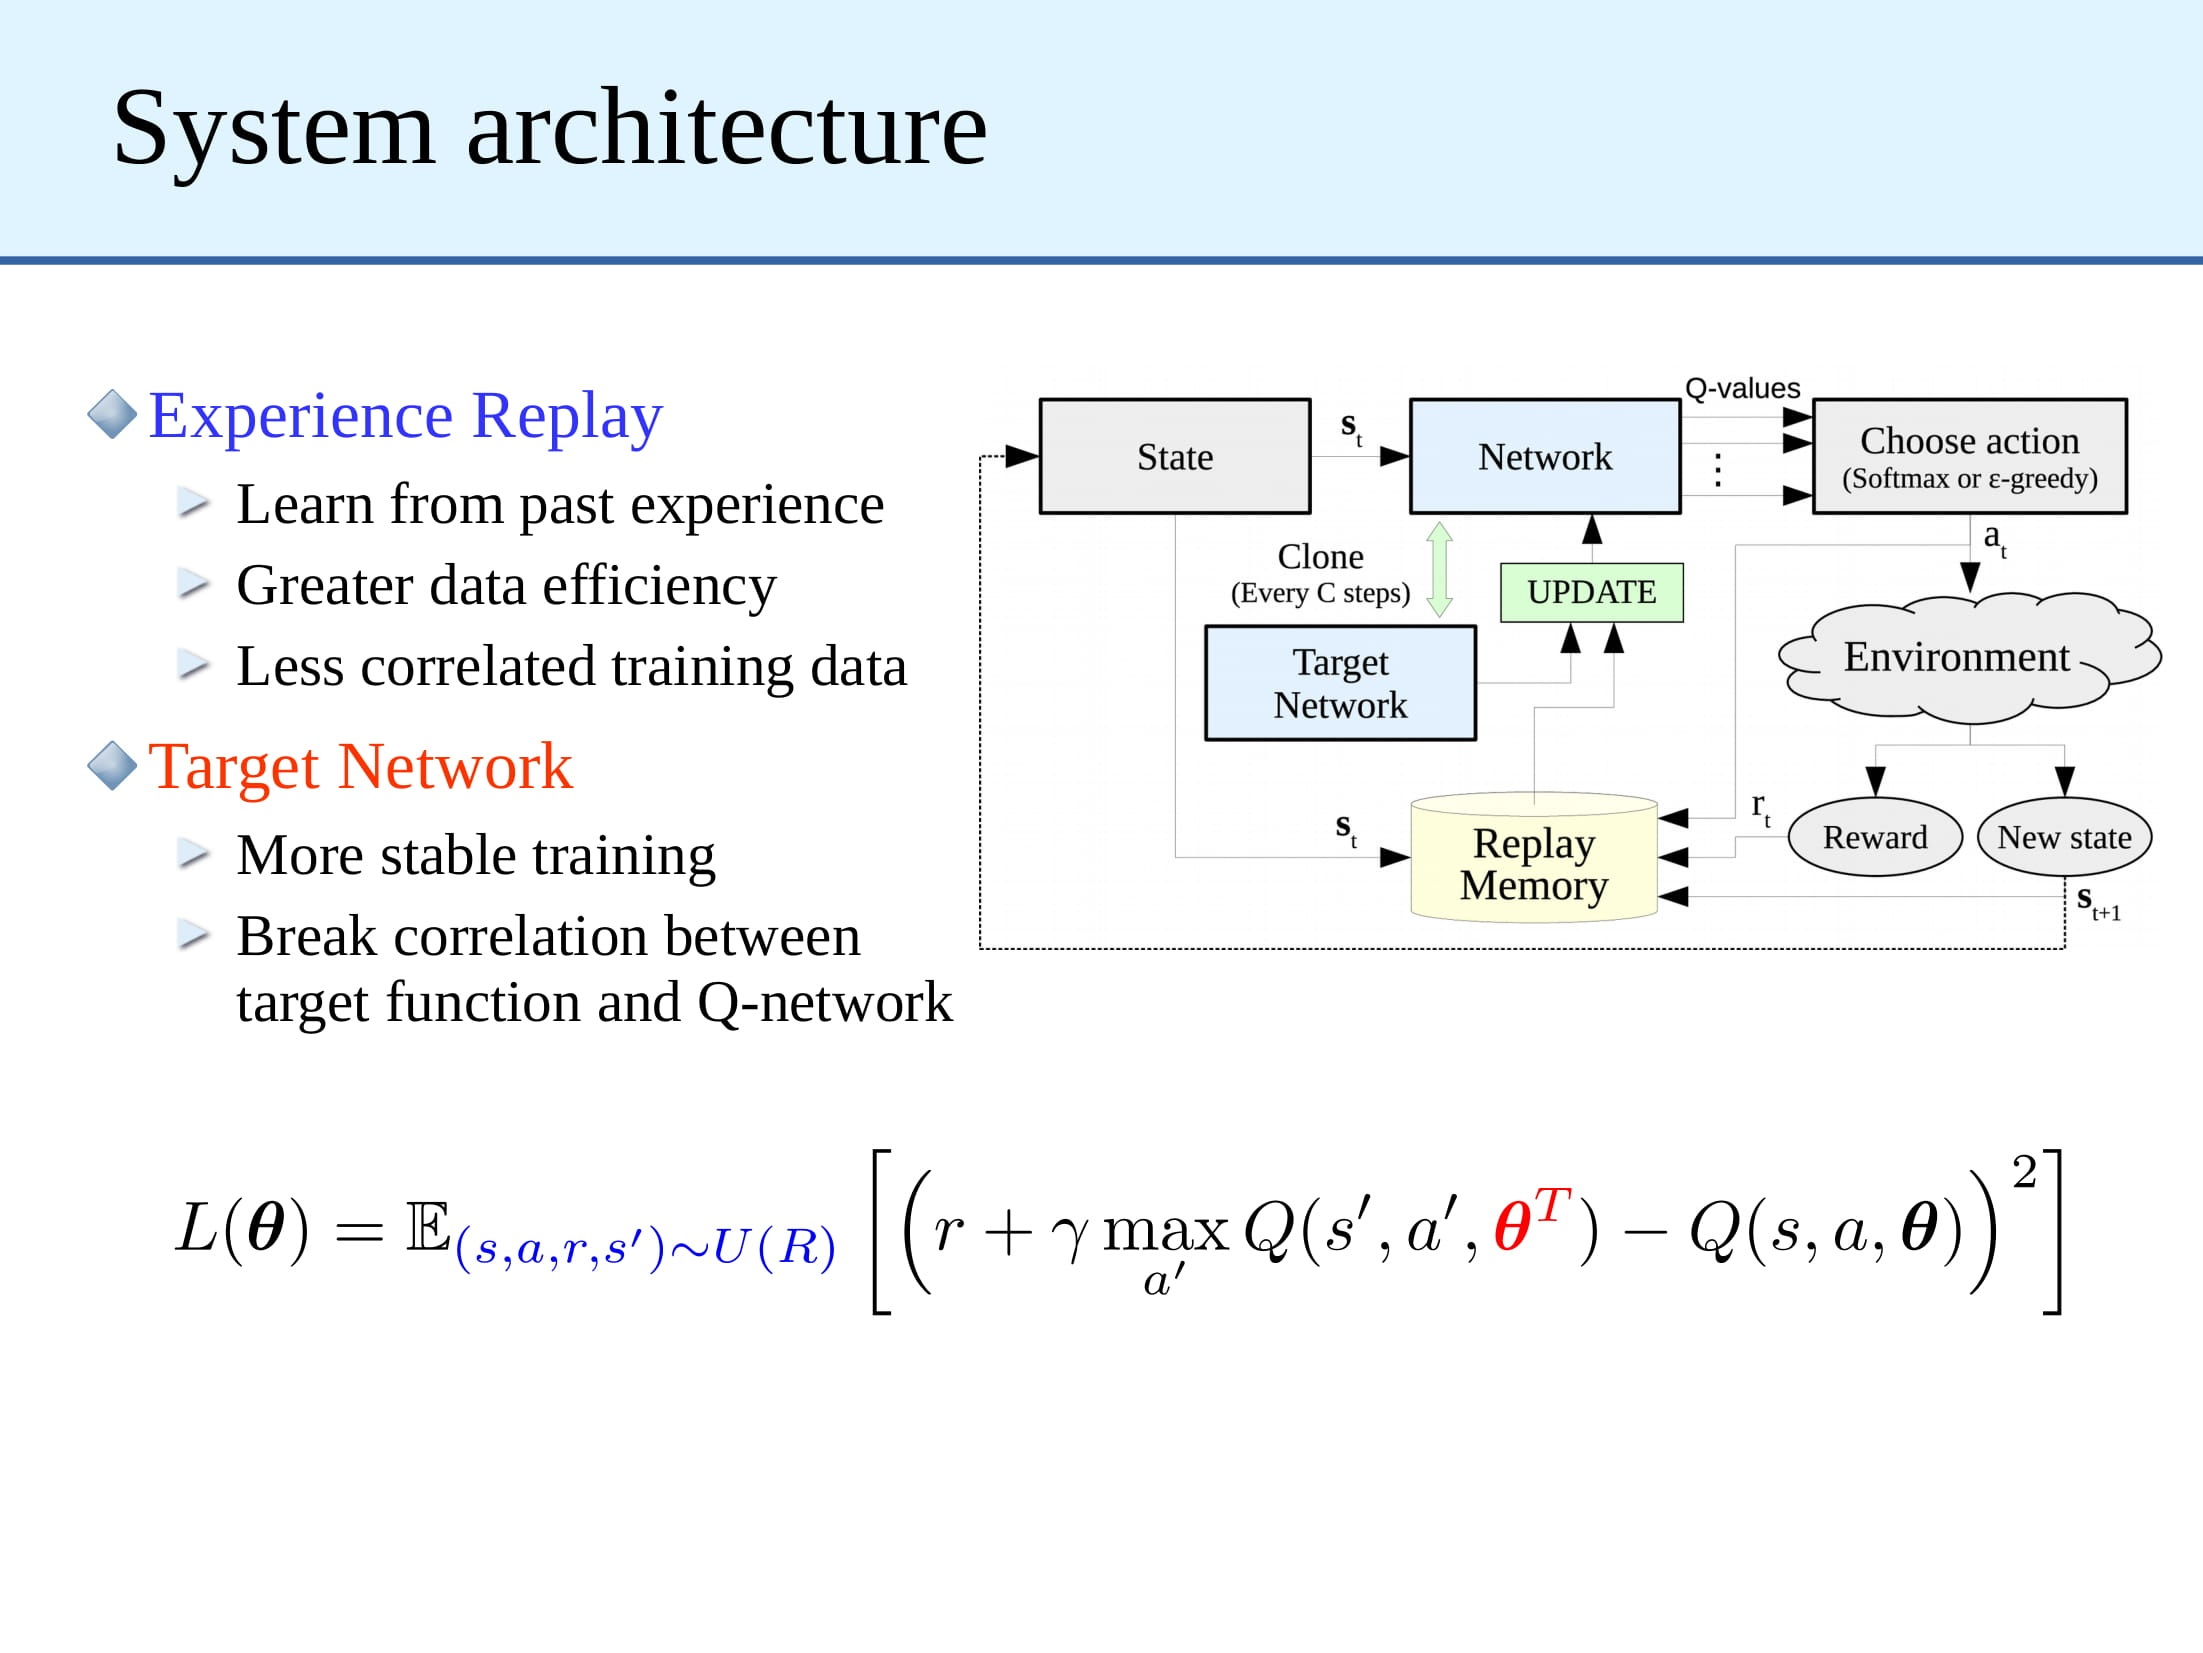

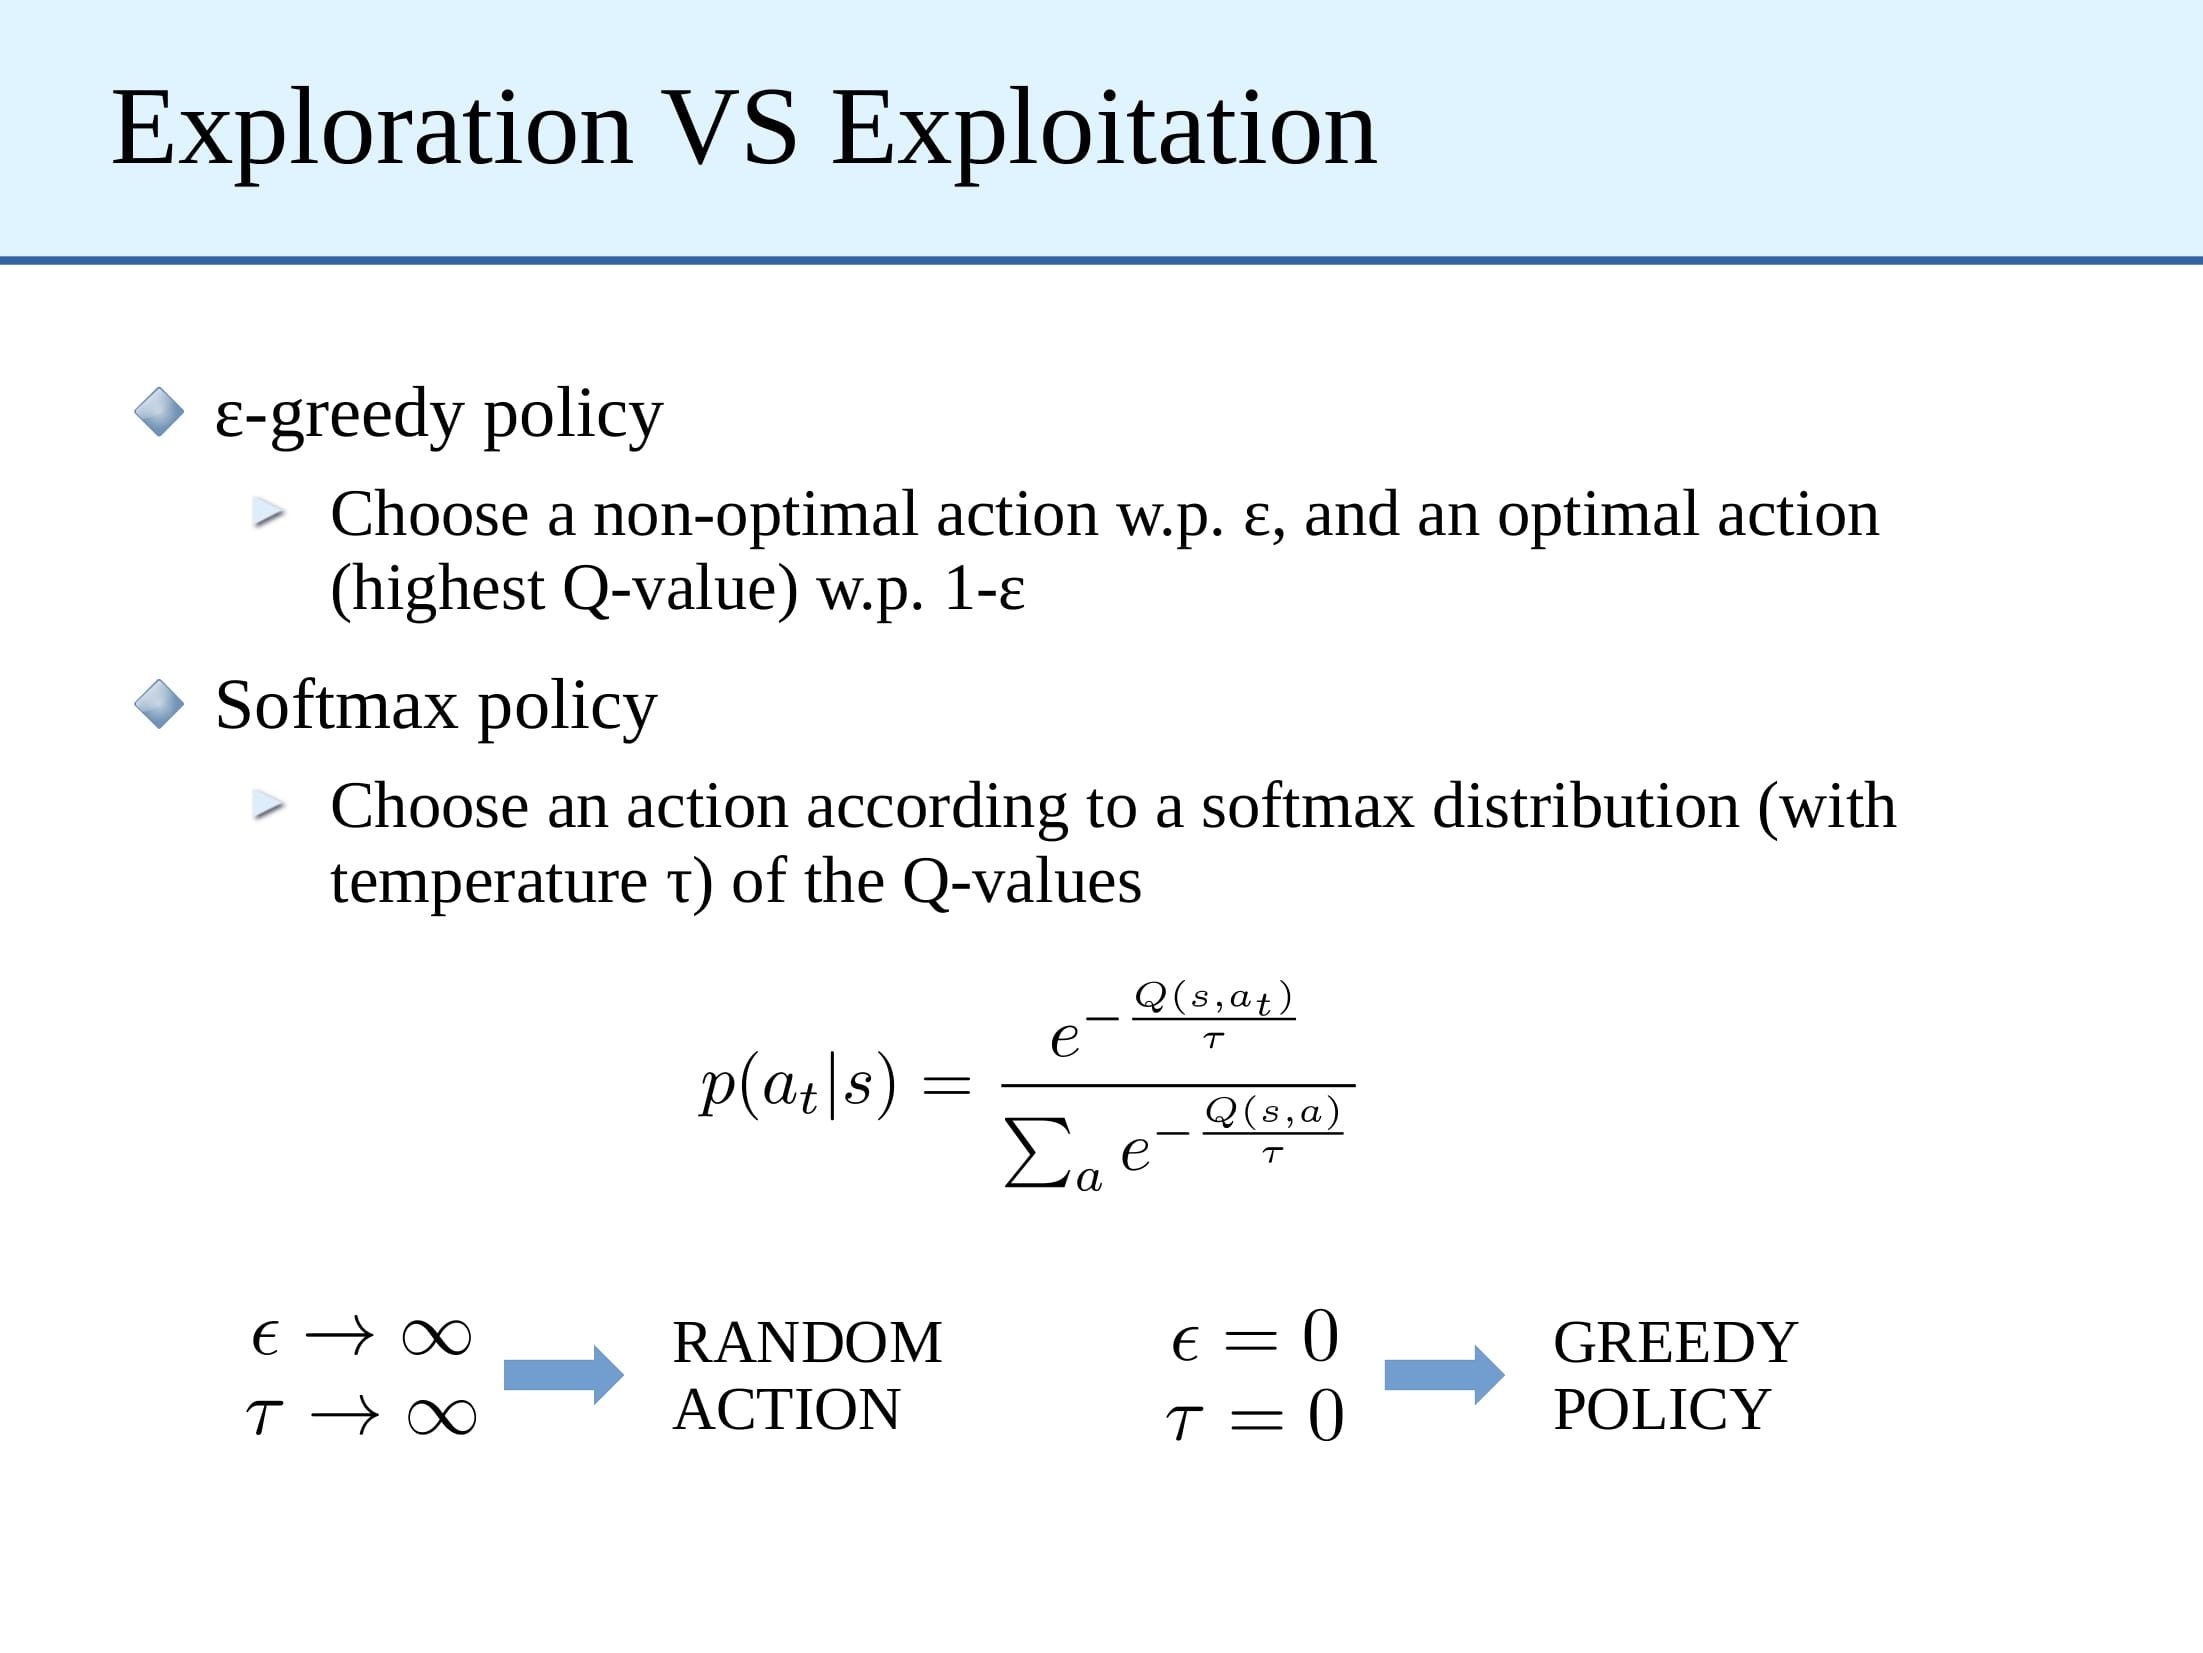

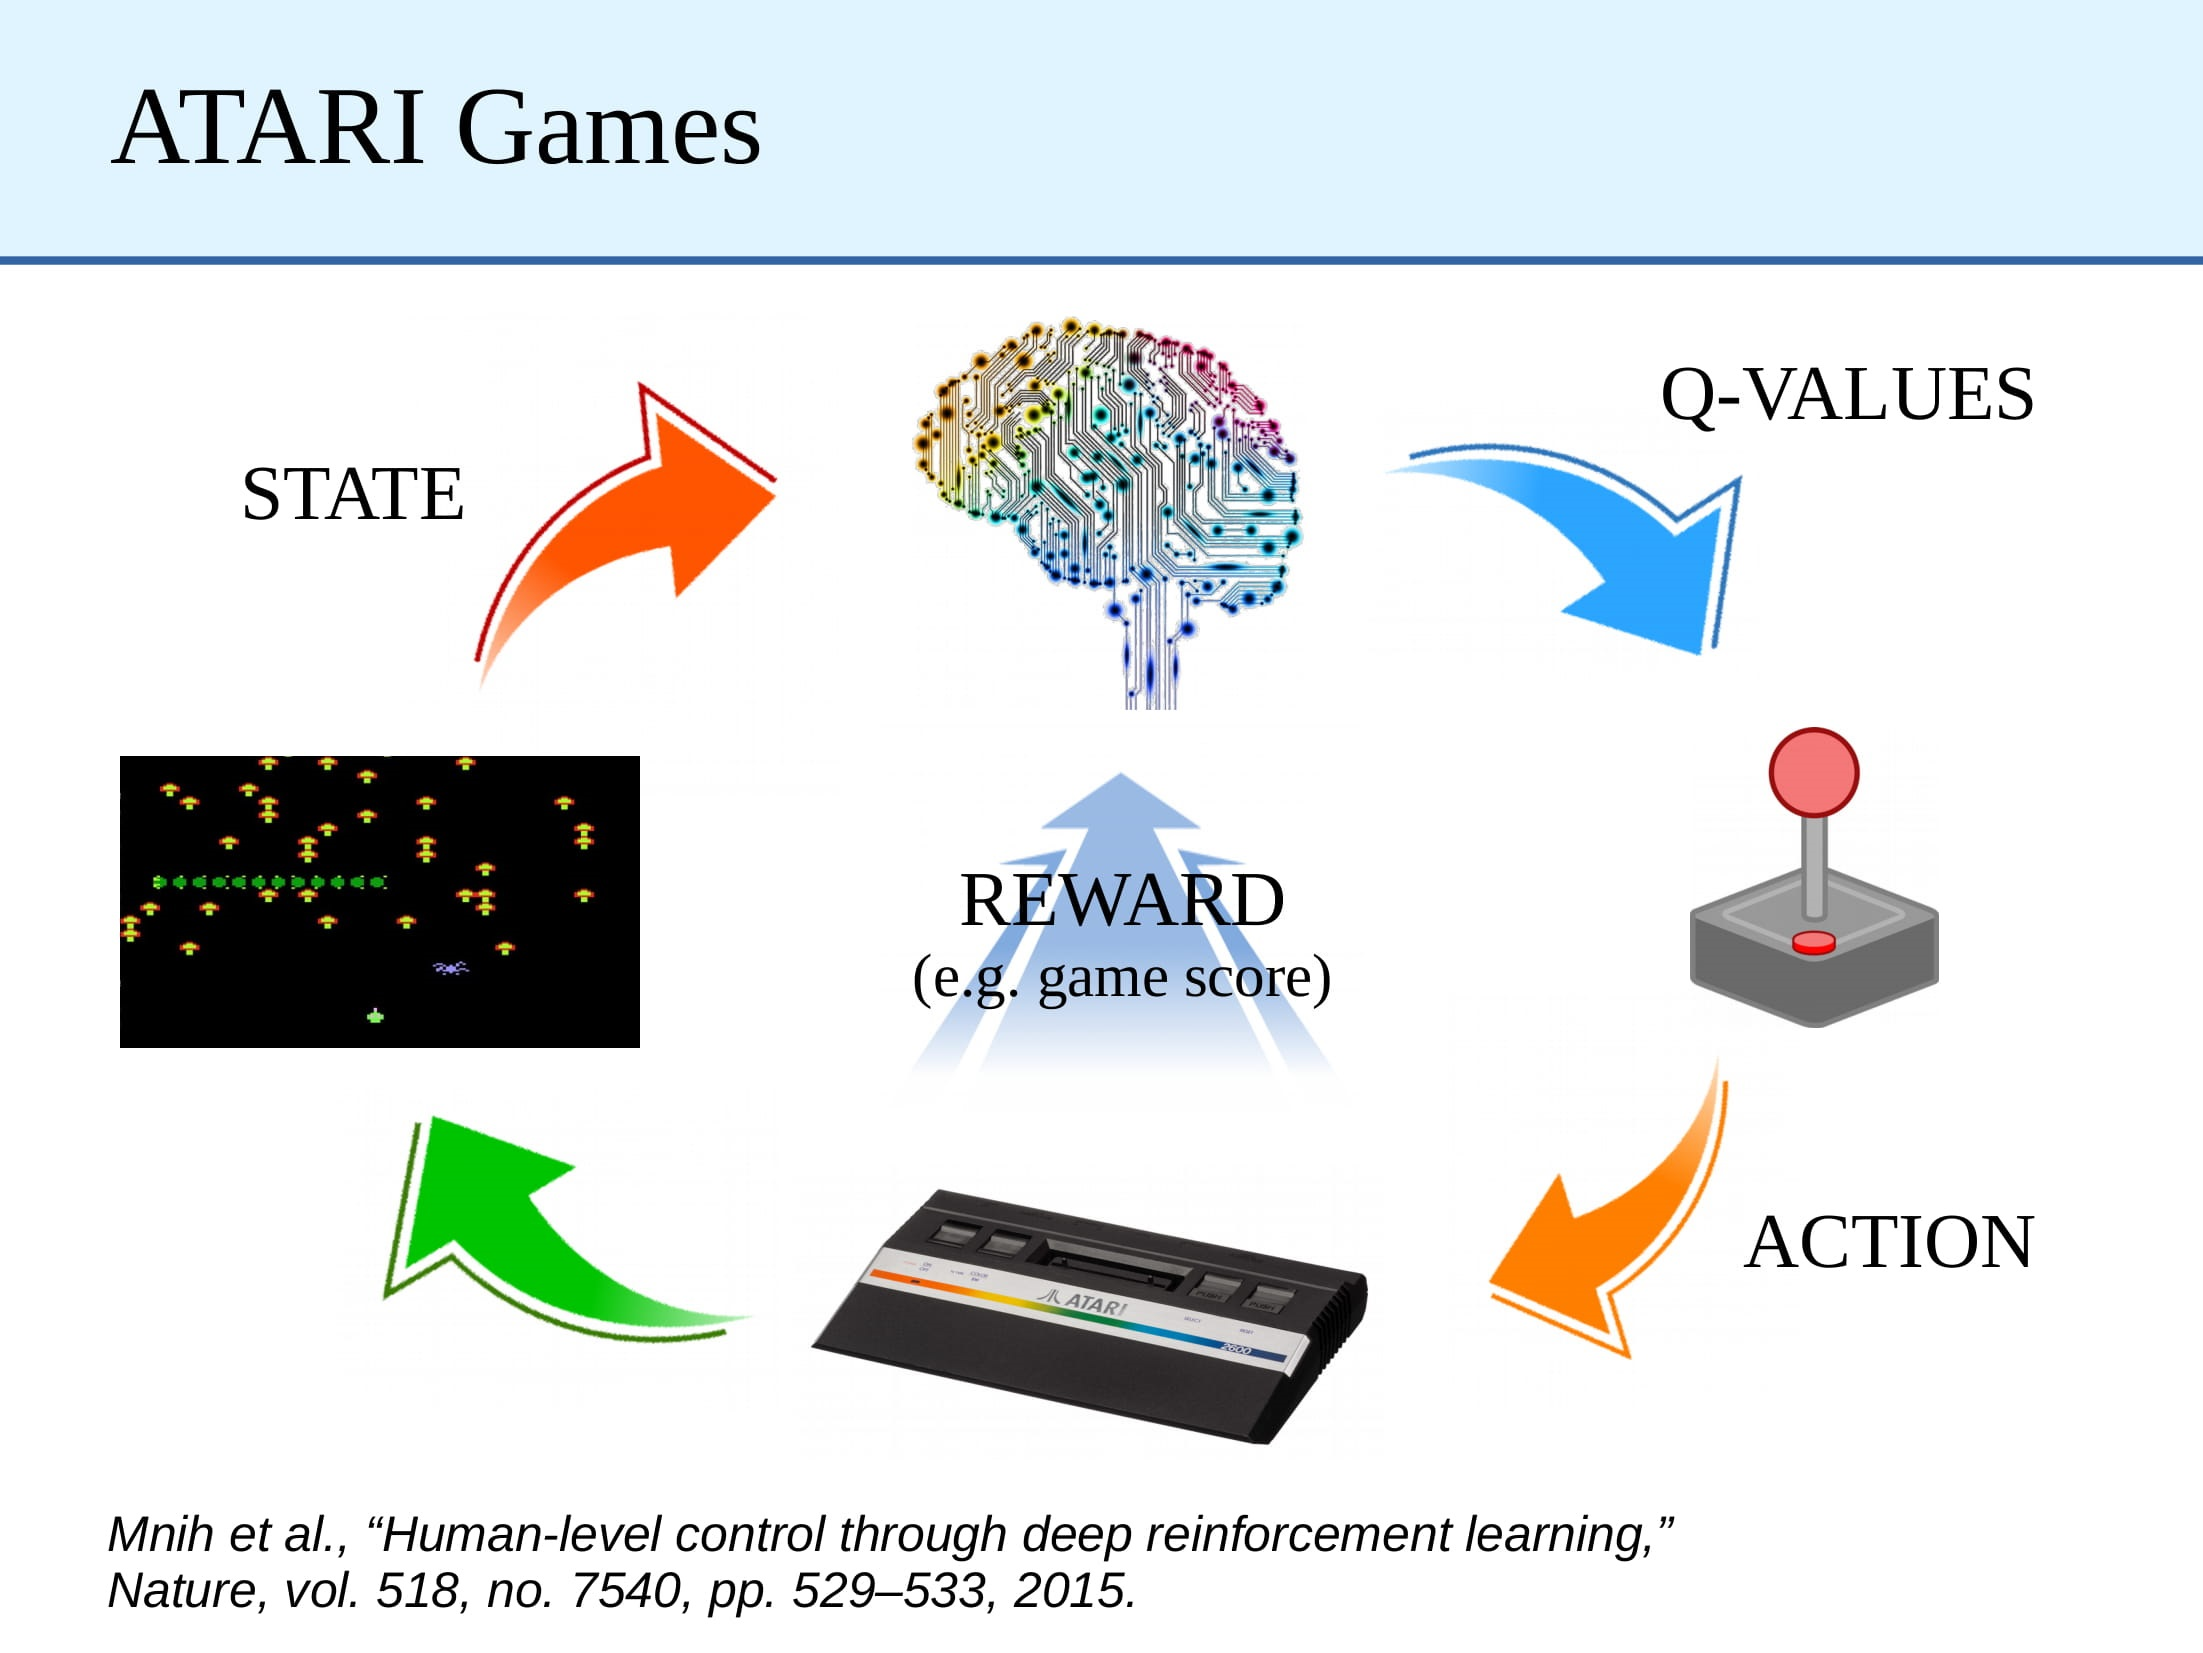

In [1]:
#!pip install gym

In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from optuna.trial import TrialState
import optuna

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

# Enable gym environment rendering in Docker Jupyter server

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [3]:
# !apt update
# !apt-get install python-opengl -y
# !apt install xvfb -y
# !pip install pyvirtualdisplay
# !pip install piglet

In [4]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
    mp4list = glob.glob('video/*.mp4')
    mp4list.sort()
    for mp4 in mp4list:
        print(f"\nSHOWING VIDEO {mp4}")
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))

def wrap_env(env, folder : str ,  video_callable = None):
    env = Monitor(env, './'+folder+'_video', force = True, video_callable = video_callable)
    return env

# Experience replay (Replay Memory)

"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

Source: https://www.nature.com/articles/nature14236

In practice, what we need is a queue with a predefined capacity. When we reach the maximum capacity, the oldest element in the queue will be replaced with the new one.

This exact behavior is implemented by the `deque` object from the python `collections` library (https://docs.python.org/3/library/collections.html#collections.deque):

"*If maxlen is not specified or is None, deques may grow to an arbitrary length. Otherwise, the deque is bounded to the specified maximum length. Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end.*"

The random sampling can be easily achieved using the `random.sample` method (https://docs.python.org/3/library/random.html). 

In [8]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 64 neurons each). 

Be sure to keep a linear output activation.

## Network definition

In [9]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [10]:
# Define an example network
net = DQN(state_space_dim = 4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values, we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [11]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

> **HINT**
>
> To sample from a random (discrete) distribution you can use the numpy function `numpy.random.choice` (https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html), by setting the parameter `p` properly.

> **HINT**
>
> Even if the PyTorch softmax function does not support the temperature parameter directly, you can still use it and apply the temperature outside the function. Just look carefully at the softmax formula in the slide above.

> **HINT**
>
> The softmax function may be numerically unstable with very low temperature values. In practice, it is suggested to set a minimum value for the temperature (e.g. 1e-8).

In [12]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

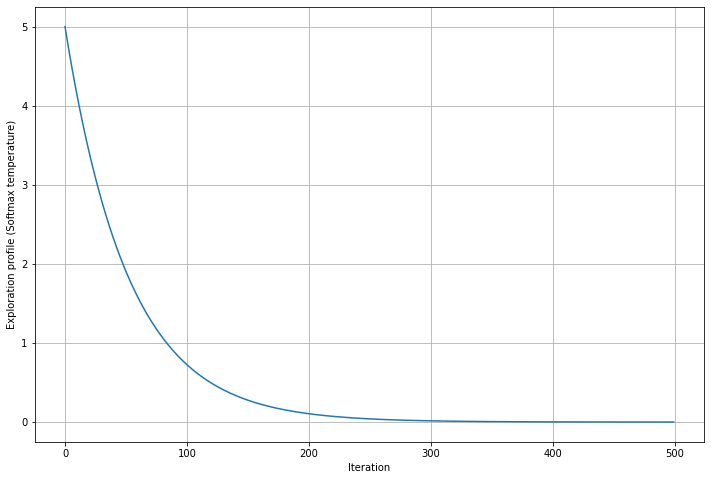

In [13]:
### Define exploration profile
initial_value = 5
#num_iterations = 1000
num_iterations = 500
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

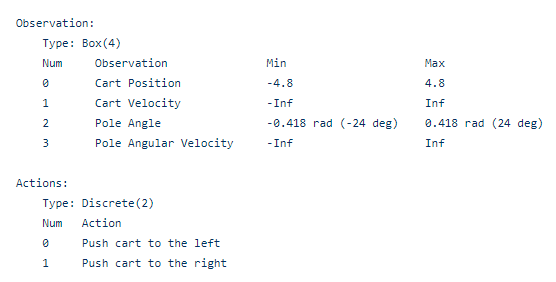

In [14]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [15]:
# Set random seeds
seed = 753
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [16]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [17]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop

In [19]:
def get_exploration_profile(initial_value, num_iterations):
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    return [initial_value * (exp_decay ** i) for i in range(num_iterations)]

In [20]:
def initialize_networks(state_space_dim = 4, action_space_dim = 2, replay_memory_capacity = 1000, lr = 1e-2):
    
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
    
    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [21]:
class my_metrics():
    def __init__(self):
        self.solved = False
        self.n_iter = None
    
    def update(self, solved : bool, when : int):
        if self.solved == False:
            self.solved = True
            self.n_iter = when
            return
        else:
            return        
        
    def get_info(self):
        return self.solved, self.n_iter
    
    def get_solved_bool(self):
        return self.solved
    
    def force_to_max_iter(self, max_iter):
        if self.solved == False:
            self.n_iter = max_iter
        return 

In [22]:
def zero_to_epsilon(value, epsilon = 1e-5):
    if value < epsilon:
        return epsilon
    else:
        return value

In [23]:
class exploration_profile():
    def __init__(self, explor_type, initial_temp, num_iterations):
        '''
        Explor type can take 4 different values:
        - 0 linear decay
        - 1 exponential decay
        '''
        self.length  = num_iterations
        self.initial = initial_temp
        self.where = []
        if explor_type == 0:
            n_steps = num_iterations/2
            delta   = initial_temp/n_steps
            self.profile =  [zero_to_epsilon(initial_temp - i*delta) for i in range(num_iterations)]
        if explor_type == 1:
            decay = np.exp(-np.log(initial_temp) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
            self.profile = [initial_temp * (decay ** i) for i in range(num_iterations)]
        return 
    
    def get_profile(self):
        return np.array(self.profile)
    
    def add_noise(self, mean = 0., sigma = 1., ampl = 1.):
        if (mean == 0.):
            mean  = np.random.randint(1 , self.length)
        sigma = self.length/50
        ampl  = self.initial*5
        self.where.append((mean, sigma))
        
        noise = np.array([ampl * np.exp(-0.5 * (i - mean)**2/sigma**2) / (sigma * np.sqrt(2*np.pi)) for i in range(self.length)])
        self.profile += noise
        return 
    
    def plot_profile(self):
        plt.plot(self.profile)
        plt.xlabel("Episode")
        plt.ylabel("Temperature")
        plt.show()
        return
    
    def get_where_noise(self):
        return self.where

In [24]:
class results_storage():
    def __init__(self):
        self.profiles_list = []
        self.scores = []
        return
    
    def add_profile(self, exploration_profile):
        self.profiles_list.append(exploration_profile)
        return
    
    def add_scores(self, score_list):
        self.scores.append(score_list)
        return
    
    def get_profile(self, n : int):
        return self.profiles_list[n]
    
    def get_score(self, n : int):
        return self.scores[n]
    
    def plot_profile_score(self, n : int, save_flag = False):
        profile  = self.get_profile(n)
        score    = self.get_score(n)
        max_temp = profile[0]
        scale = 500//max_temp # 500//9 = 55
        
        plt.plot(scale*profile, label = str(scale)+'*Temperature')
        plt.plot(np.array(score), label = 'Score')
        plt.xlabel("Episodes")
        plt.ylabel("")
        plt.legend()
        
        if save_flag: plt.savefig('best_CartPole.png')
            
        plt.show()
        
        return 

In [25]:
MAX_ITER = 1000
train_dict = {
    'state_space_dim': 4,
    'action_space_dim': 2,
    'replay_memory_capacity': 1000,
    'lr' : 1e-2,
    'batch_size': 128,
}


def objective(trial):

    type_profile = trial.suggest_int("type_profile", 0, 1)
    n_noise      = trial.suggest_int("noises", 0, 4)
    initial_temp = trial.suggest_int("max_temp", 1, 15)
    gamma        = trial.suggest_float("gamma", 0.9, 0.99)
    multiple_update_steps   = trial.suggest_int("target_net_update_steps", 1,5)
    target_net_update_steps = int(5*multiple_update_steps)
    
    
    ### Initialize the replay memory
    replay_mem = ReplayMemory(5000)    

    ### Initialize the policy network
    policy_net = DQN(4, 2)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(4, 2)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=1e-2) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(seed) # Set a random seed for the environment (reproducible results)
    
    solved_metric = my_metrics()
    profile_obj = exploration_profile(type_profile, initial_temp, MAX_ITER)
    for i in range(n_noise):
        profile_obj.add_noise()
    profile = profile_obj.get_profile()
    my_results.add_profile(profile)
    
    score_list = []
    temp_list  = []
    loss_fn = nn.SmoothL1Loss()
    
    for episode_num, tau in enumerate(tqdm(profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done  = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            pos_weight = 1
            reward = reward - pos_weight * np.abs(state[0]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, train_dict.get('batch_size'))

            # Set the current state for the next iteration
            state = next_state
            
            if (score >= 490):
                solved_metric.update(True, episode_num)

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
        
        score_list.append(score)
        temp_list.append(tau)
    
    my_results.add_scores(score_list)
    #if there was no convergence, then set as number of iterations needed the maximal number 
    #of episodes considered
    if solved_metric.get_solved_bool() == False: 
        solved_metric.force_to_max_iter(MAX_ITER)
        
    env.close()
    return np.mean(np.array(score_list)), solved_metric.get_info()[1]

In [26]:
my_results = results_storage()

study = optuna.create_study(directions=["maximize", "minimize"])

[I 2021-08-24 08:03:58,369] A new study created in memory with name: no-name-34913012-e333-47ae-a795-353560f15b1b


In [27]:
study.optimize(objective, n_trials = 50)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

[I 2021-08-24 08:10:00,009] Trial 0 finished with values: [68.406, 520.0] and parameters: {'type_profile': 0, 'noises': 4, 'max_temp': 12, 'gamma': 0.9570673659805952, 'target_net_update_steps': 3}. 


[I 2021-08-24 08:14:41,362] Trial 1 finished with values: [56.72, 1000.0] and parameters: {'type_profile': 1, 'noises': 2, 'max_temp': 2, 'gamma': 0.9397630234925355, 'target_net_update_steps': 4}. 


[I 2021-08-24 08:20:30,705] Trial 2 finished with values: [70.576, 595.0] and parameters: {'type_profile': 1, 'noises': 2, 'max_temp': 5, 'gamma': 0.9270238034437084, 'target_net_update_steps': 5}. 


[I 2021-08-24 08:26:26,602] Trial 3 finished with values: [71.807, 1000.0] and parameters: {'type_profile': 1, 'noises': 0, 'max_temp': 14, 'gamma': 0.9337380534777088, 'target_net_update_steps': 2}. 


[I 2021-08-24 08:32:21,194] Trial 4 finished with values: [72.472, 522.0] and parameters: {'type_profile': 0, 'noises': 0, 'max_temp': 12, 'gamma': 0.9262077491748425, 'target_net_update_steps': 4}. 


[I 2021-08-24 08:38:41,840] Trial 5 finished with values: [77.508, 1000.0] and parameters: {'type_profile': 1, 'noises': 1, 'max_temp': 13, 'gamma': 0.970023678960005, 'target_net_update_steps': 5}. 


[I 2021-08-24 08:44:15,827] Trial 6 finished with values: [68.476, 761.0] and parameters: {'type_profile': 0, 'noises': 0, 'max_temp': 12, 'gamma': 0.9790865777399765, 'target_net_update_steps': 2}. 


[I 2021-08-24 08:49:40,063] Trial 7 finished with values: [66.511, 945.0] and parameters: {'type_profile': 1, 'noises': 3, 'max_temp': 4, 'gamma': 0.9551864812311106, 'target_net_update_steps': 3}. 


[I 2021-08-24 08:54:20,399] Trial 8 finished with values: [57.746, 538.0] and parameters: {'type_profile': 0, 'noises': 4, 'max_temp': 15, 'gamma': 0.9125595840340411, 'target_net_update_steps': 3}. 


[I 2021-08-24 08:58:28,440] Trial 9 finished with values: [51.288, 681.0] and parameters: {'type_profile': 0, 'noises': 2, 'max_temp': 6, 'gamma': 0.912561369568806, 'target_net_update_steps': 5}. 


[I 2021-08-24 09:10:07,438] Trial 10 finished with values: [142.319, 707.0] and parameters: {'type_profile': 0, 'noises': 2, 'max_temp': 4, 'gamma': 0.9891613535284965, 'target_net_update_steps': 1}. 


[I 2021-08-24 09:16:16,850] Trial 11 finished with values: [75.535, 1000.0] and parameters: {'type_profile': 1, 'noises': 0, 'max_temp': 12, 'gamma': 0.9184037500376799, 'target_net_update_steps': 5}. 


[I 2021-08-24 09:32:48,420] Trial 12 finished with values: [202.304, 613.0] and parameters: {'type_profile': 1, 'noises': 4, 'max_temp': 4, 'gamma': 0.959083720610417, 'target_net_update_steps': 1}. 


[I 2021-08-24 09:40:44,965] Trial 13 finished with values: [97.617, 528.0] and parameters: {'type_profile': 0, 'noises': 1, 'max_temp': 14, 'gamma': 0.9571239817020893, 'target_net_update_steps': 1}. 


[I 2021-08-24 09:47:41,446] Trial 14 finished with values: [85.357, 584.0] and parameters: {'type_profile': 0, 'noises': 2, 'max_temp': 14, 'gamma': 0.9388471161177356, 'target_net_update_steps': 1}. 


[I 2021-08-24 09:54:28,908] Trial 15 finished with values: [83.381, 539.0] and parameters: {'type_profile': 0, 'noises': 2, 'max_temp': 11, 'gamma': 0.9563549746548502, 'target_net_update_steps': 2}. 


[I 2021-08-24 10:01:20,293] Trial 16 finished with values: [83.789, 775.0] and parameters: {'type_profile': 1, 'noises': 4, 'max_temp': 14, 'gamma': 0.9764890947511995, 'target_net_update_steps': 5}. 


[I 2021-08-24 10:07:34,858] Trial 17 finished with values: [76.584, 504.0] and parameters: {'type_profile': 0, 'noises': 4, 'max_temp': 8, 'gamma': 0.9317004925723841, 'target_net_update_steps': 2}. 


[I 2021-08-24 10:12:31,542] Trial 18 finished with values: [60.78, 518.0] and parameters: {'type_profile': 0, 'noises': 3, 'max_temp': 12, 'gamma': 0.9700835633506069, 'target_net_update_steps': 4}. 


[I 2021-08-24 10:16:30,475] Trial 19 finished with values: [49.202, 1000.0] and parameters: {'type_profile': 0, 'noises': 0, 'max_temp': 9, 'gamma': 0.9103092993321562, 'target_net_update_steps': 1}. 


[I 2021-08-24 10:22:00,598] Trial 20 finished with values: [67.58, 1000.0] and parameters: {'type_profile': 0, 'noises': 3, 'max_temp': 2, 'gamma': 0.989677396895821, 'target_net_update_steps': 5}. 


[I 2021-08-24 10:28:04,467] Trial 21 finished with values: [74.152, 945.0] and parameters: {'type_profile': 0, 'noises': 0, 'max_temp': 1, 'gamma': 0.9362179352149121, 'target_net_update_steps': 4}. 


[I 2021-08-24 10:33:26,686] Trial 22 finished with values: [65.856, 1000.0] and parameters: {'type_profile': 1, 'noises': 3, 'max_temp': 4, 'gamma': 0.9521820993392797, 'target_net_update_steps': 4}. 


[I 2021-08-24 10:39:39,828] Trial 23 finished with values: [76.423, 487.0] and parameters: {'type_profile': 0, 'noises': 3, 'max_temp': 6, 'gamma': 0.9871646439140286, 'target_net_update_steps': 3}. 


[I 2021-08-24 10:52:43,606] Trial 24 finished with values: [160.123, 786.0] and parameters: {'type_profile': 1, 'noises': 2, 'max_temp': 13, 'gamma': 0.9390689987231128, 'target_net_update_steps': 1}. 


[I 2021-08-24 10:56:47,358] Trial 25 finished with values: [50.329, 1000.0] and parameters: {'type_profile': 0, 'noises': 2, 'max_temp': 14, 'gamma': 0.9149069811387419, 'target_net_update_steps': 1}. 


[I 2021-08-24 11:01:57,637] Trial 26 finished with values: [63.794, 1000.0] and parameters: {'type_profile': 1, 'noises': 4, 'max_temp': 10, 'gamma': 0.9658877943044138, 'target_net_update_steps': 4}. 


[I 2021-08-24 11:09:19,410] Trial 27 finished with values: [90.481, 515.0] and parameters: {'type_profile': 0, 'noises': 2, 'max_temp': 12, 'gamma': 0.9413355061193289, 'target_net_update_steps': 5}. 


[I 2021-08-24 11:28:49,239] Trial 28 finished with values: [237.203, 537.0] and parameters: {'type_profile': 0, 'noises': 0, 'max_temp': 4, 'gamma': 0.9763751318112043, 'target_net_update_steps': 1}. 


[I 2021-08-24 11:35:05,531] Trial 29 finished with values: [76.92, 512.0] and parameters: {'type_profile': 0, 'noises': 0, 'max_temp': 8, 'gamma': 0.9617238546018229, 'target_net_update_steps': 2}. 


[I 2021-08-24 11:40:47,842] Trial 30 finished with values: [70.004, 492.0] and parameters: {'type_profile': 0, 'noises': 0, 'max_temp': 3, 'gamma': 0.9602758843527359, 'target_net_update_steps': 3}. 


[I 2021-08-24 11:45:59,023] Trial 31 finished with values: [63.715, 1000.0] and parameters: {'type_profile': 1, 'noises': 2, 'max_temp': 2, 'gamma': 0.9888189270877198, 'target_net_update_steps': 5}. 


[I 2021-08-24 11:51:03,084] Trial 32 finished with values: [61.927, 627.0] and parameters: {'type_profile': 0, 'noises': 1, 'max_temp': 12, 'gamma': 0.9625079338094331, 'target_net_update_steps': 2}. 


[I 2021-08-24 11:55:47,017] Trial 33 finished with values: [58.074, 503.0] and parameters: {'type_profile': 0, 'noises': 2, 'max_temp': 12, 'gamma': 0.9278091129724069, 'target_net_update_steps': 4}. 


[I 2021-08-24 12:00:40,707] Trial 34 finished with values: [60.198, 1000.0] and parameters: {'type_profile': 1, 'noises': 3, 'max_temp': 3, 'gamma': 0.9378190086783501, 'target_net_update_steps': 3}. 


[I 2021-08-24 12:06:42,623] Trial 35 finished with values: [73.931, 1000.0] and parameters: {'type_profile': 1, 'noises': 4, 'max_temp': 3, 'gamma': 0.9625922683835486, 'target_net_update_steps': 3}. 


[I 2021-08-24 12:25:24,064] Trial 36 finished with values: [228.11, 588.0] and parameters: {'type_profile': 1, 'noises': 3, 'max_temp': 4, 'gamma': 0.9656682492304675, 'target_net_update_steps': 1}. 


[I 2021-08-24 12:29:59,563] Trial 37 finished with values: [56.638, 1000.0] and parameters: {'type_profile': 0, 'noises': 3, 'max_temp': 9, 'gamma': 0.9630719250181711, 'target_net_update_steps': 3}. 


[I 2021-08-24 12:41:29,082] Trial 38 finished with values: [140.555, 798.0] and parameters: {'type_profile': 1, 'noises': 4, 'max_temp': 14, 'gamma': 0.9746921440397821, 'target_net_update_steps': 2}. 


[I 2021-08-24 12:46:44,348] Trial 39 finished with values: [64.634, 503.0] and parameters: {'type_profile': 0, 'noises': 3, 'max_temp': 2, 'gamma': 0.9167698088257827, 'target_net_update_steps': 1}. 


[I 2021-08-24 12:51:21,637] Trial 40 finished with values: [56.757, 1000.0] and parameters: {'type_profile': 0, 'noises': 2, 'max_temp': 5, 'gamma': 0.9386689773771804, 'target_net_update_steps': 4}. 


[I 2021-08-24 12:56:58,226] Trial 41 finished with values: [69.193, 528.0] and parameters: {'type_profile': 0, 'noises': 2, 'max_temp': 15, 'gamma': 0.908668717945244, 'target_net_update_steps': 4}. 


[I 2021-08-24 13:03:08,524] Trial 42 finished with values: [75.827, 669.0] and parameters: {'type_profile': 1, 'noises': 4, 'max_temp': 8, 'gamma': 0.9264441355045977, 'target_net_update_steps': 4}. 


[I 2021-08-24 13:09:18,220] Trial 43 finished with values: [75.556, 961.0] and parameters: {'type_profile': 1, 'noises': 3, 'max_temp': 6, 'gamma': 0.9400953771278814, 'target_net_update_steps': 5}. 


[I 2021-08-24 13:13:44,148] Trial 44 finished with values: [54.411, 1000.0] and parameters: {'type_profile': 1, 'noises': 4, 'max_temp': 3, 'gamma': 0.9330075238214885, 'target_net_update_steps': 3}. 


[I 2021-08-24 13:21:26,025] Trial 45 finished with values: [94.626, 592.0] and parameters: {'type_profile': 1, 'noises': 3, 'max_temp': 12, 'gamma': 0.9359825339494791, 'target_net_update_steps': 1}. 


[I 2021-08-24 13:26:57,152] Trial 46 finished with values: [67.656, 1000.0] and parameters: {'type_profile': 1, 'noises': 1, 'max_temp': 10, 'gamma': 0.9104824935351745, 'target_net_update_steps': 5}. 


[I 2021-08-24 13:32:39,060] Trial 47 finished with values: [70.098, 502.0] and parameters: {'type_profile': 0, 'noises': 4, 'max_temp': 3, 'gamma': 0.9270406095410285, 'target_net_update_steps': 4}. 


[I 2021-08-24 13:38:52,946] Trial 48 finished with values: [76.613, 1000.0] and parameters: {'type_profile': 1, 'noises': 1, 'max_temp': 7, 'gamma': 0.9339001828918685, 'target_net_update_steps': 5}. 


[I 2021-08-24 13:52:02,872] Trial 49 finished with values: [160.909, 713.0] and parameters: {'type_profile': 1, 'noises': 4, 'max_temp': 7, 'gamma': 0.946051313841739, 'target_net_update_steps': 1}. 



Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50


In [28]:
optuna.visualization.plot_pareto_front(study, target_names=["Average Score","Velocity"])

/tmp/ipykernel_10800/2551249137.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.4.0). The interface can change in the future.
  optuna.visualization.plot_pareto_front(study, target_names=["Average Score","Velocity"])


In [29]:
optuna.visualization.plot_param_importances(
    study, target = lambda t: t.values[0], target_name = "Average Score"
)

In [30]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[1], target_name = "Velocity"
)

In [31]:
trials_df = study.trials_dataframe()
trials_df.to_csv('optuna_first.csv')

trials_df

number  values_0  values_1             datetime_start  \
0        0    68.406     520.0 2021-08-24 08:04:22.722317   
1        1    56.720    1000.0 2021-08-24 08:10:00.010726   
2        2    70.576     595.0 2021-08-24 08:14:41.363600   
3        3    71.807    1000.0 2021-08-24 08:20:30.706793   
4        4    72.472     522.0 2021-08-24 08:26:26.603600   
5        5    77.508    1000.0 2021-08-24 08:32:21.195672   
6        6    68.476     761.0 2021-08-24 08:38:41.841040   
7        7    66.511     945.0 2021-08-24 08:44:15.828306   
8        8    57.746     538.0 2021-08-24 08:49:40.064187   
9        9    51.288     681.0 2021-08-24 08:54:20.400170   
10      10   142.319     707.0 2021-08-24 08:58:28.441120   
11      11    75.535    1000.0 2021-08-24 09:10:07.439181   
12      12   202.304     613.0 2021-08-24 09:16:16.851470   
13      13    97.617     528.0 2021-08-24 09:32:48.421047   
14      14    85.357     584.0 2021-08-24 09:40:44.966737   
15      15    83.381     539.0 2021-08-24 09:47:41.447677   
16      16    83.789     775.0 2021-08-24 09:54:28.909805   
17      17    76.584     504.0 2021-08-24 10:01:20.294117   
18      18    60.780     518.0 2021-08-24 10:07:34.858987   
19      19    49.202    1000.0 2021-08-24 10:12:31.543346   
20      20    67.580    1000.0 2021-08-24 10:16:30.476601   
21      21    74.152     945.0 2021-08-24 10:22:00.598880   
22      22    65.856    1000.0 2021-08-24 10:28:04.468660   
23      23    76.423     487.0 2021-08-24 10:33:26.686940   
24      24   160.123     786.0 2021-08-24 10:39:39.829462   
25      25    50.329    1000.0 2021-08-24 10:52:43.607219   
26      26    63.794    1000.0 2021-08-24 10:56:47.359356   
27      27    90.481     515.0 2021-08-24 11:01:57.638896   
28      28   237.203     537.0 2021-08-24 11:09:19.411116   
29      29    76.920     512.0 2021-08-24 11:28:49.240586   
30      30    70.004     492.0 2021-08-24 11:35:05.532376   
31      31    63.715    1000.0 2021-08-24 11:40:47.843354   
32      32    61.927     627.0 2021-08-24 11:45:59.024113   
33      33    58.074     503.0 2021-08-24 11:51:03.085630   
34      34    60.198    1000.0 2021-08-24 11:55:47.018466   
35      35    73.931    1000.0 2021-08-24 12:00:40.708659   
36      36   228.110     588.0 2021-08-24 12:06:42.624007   
37      37    56.638    1000.0 2021-08-24 12:25:24.065785   
38      38   140.555     798.0 2021-08-24 12:29:59.564314   
39      39    64.634     503.0 2021-08-24 12:41:29.083924   
40      40    56.757    1000.0 2021-08-24 12:46:44.349160   
41      41    69.193     528.0 2021-08-24 12:51:21.638653   
42      42    75.827     669.0 2021-08-24 12:56:58.227547   
43      43    75.556     961.0 2021-08-24 13:03:08.525586   
44      44    54.411    1000.0 2021-08-24 13:09:18.221053   
45      45    94.626     592.0 2021-08-24 13:13:44.149302   
46      46    67.656    1000.0 2021-08-24 13:21:26.026021   
47      47    70.098     502.0 2021-08-24 13:26:57.153583   
48      48    76.613    1000.0 2021-08-24 13:32:39.061241   
49      49   160.909     713.0 2021-08-24 13:38:52.947453   

            datetime_complete               duration  params_gamma  \
0  2021-08-24 08:10:00.009795 0 days 00:05:37.287478      0.957067   
1  2021-08-24 08:14:41.362747 0 days 00:04:41.352021      0.939763   
2  2021-08-24 08:20:30.705928 0 days 00:05:49.342328      0.927024   
3  2021-08-24 08:26:26.602669 0 days 00:05:55.895876      0.933738   
4  2021-08-24 08:32:21.194891 0 days 00:05:54.591291      0.926208   
5  2021-08-24 08:38:41.840204 0 days 00:06:20.644532      0.970024   
6  2021-08-24 08:44:15.827480 0 days 00:05:33.986440      0.979087   
7  2021-08-24 08:49:40.063348 0 days 00:05:24.235042      0.955186   
8  2021-08-24 08:54:20.399324 0 days 00:04:40.335137      0.912560   
9  2021-08-24 08:58:28.440286 0 days 00:04:08.040116      0.912561   
10 2021-08-24 09:10:07.438340 0 days 00:11:38.997220      0.989161   
11 2021-08-24 09:16:16.850609 0 days 00:06:09.411428

In [32]:
best_network_list = []
trials = study.best_trials
for ii, trial in enumerate(trials):
    fine_opt_network_dictionary = {}
    print(ii, "----- Best trial------ ")
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        fine_opt_network_dictionary.update({key:value})
    best_network_list.append(fine_opt_network_dictionary)

0 ----- Best trial------ 
  Params: 
    type_profile: 0
    noises: 1
    max_temp: 14
    gamma: 0.9571239817020893
    target_net_update_steps: 1
1 ----- Best trial------ 
  Params: 
    type_profile: 0
    noises: 4
    max_temp: 8
    gamma: 0.9317004925723841
    target_net_update_steps: 2
2 ----- Best trial------ 
  Params: 
    type_profile: 0
    noises: 3
    max_temp: 6
    gamma: 0.9871646439140286
    target_net_update_steps: 3
3 ----- Best trial------ 
  Params: 
    type_profile: 0
    noises: 2
    max_temp: 12
    gamma: 0.9413355061193289
    target_net_update_steps: 5
4 ----- Best trial------ 
  Params: 
    type_profile: 0
    noises: 0
    max_temp: 4
    gamma: 0.9763751318112043
    target_net_update_steps: 1
5 ----- Best trial------ 
  Params: 
    type_profile: 0
    noises: 0
    max_temp: 8
    gamma: 0.9617238546018229
    target_net_update_steps: 2


In [33]:
optuna.visualization.plot_parallel_coordinate(
    study, target=lambda t: t.values[1], target_name = "Velocity"
)

In [73]:
fig = optuna.visualization.plot_contour(study, 
                                        target=lambda t: t.values[0], target_name = "Average Score",
                                        params=["gamma", "max_temp"])
fig.show()

In [74]:
fig = optuna.visualization.plot_contour(study, 
                                        target=lambda t: t.values[1], target_name = "Velocity",
                                        params=["gamma", "max_temp"])
fig.show()

In [34]:
df = pd.DataFrame(best_network_list).sort_values(by = 'target_net_update_steps').reset_index(drop = True)
df

type_profile  noises  max_temp     gamma  target_net_update_steps
0             0       1        14  0.957124                        1
1             0       0         4  0.976375                        1
2             0       4         8  0.931700                        2
3             0       0         8  0.961724                        2
4             0       3         6  0.987165                        3
5             0       2        12  0.941336                        5

The best seems to be the trials 28 and 23:

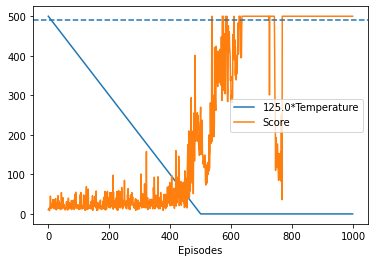

In [69]:
first_prof  = my_results.get_profile(28)
first_score = my_results.get_score(28)
best_max_temp = first_prof[0]

scale = 500//best_max_temp # 500//9 = 55
plt.plot(scale*first_prof, label = str(scale)+'*Temperature')
plt.plot(np.array(first_score), label = 'Score')
plt.axhline(490, linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("")
plt.legend()
plt.savefig('best_CartPole_first.png')
plt.show()

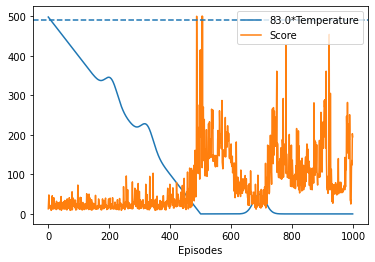

In [70]:
second_prof  = my_results.get_profile(23)
second_score = my_results.get_score(23)
best_max_temp = second_prof[0]

scale = 500//best_max_temp # 500//9 = 55
plt.plot(scale*second_prof, label = str(scale)+'*Temperature')
plt.plot(np.array(second_score), label = 'Score')
plt.axhline(490, linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("")
plt.legend()
plt.savefig('best_CartPole_second.png')
plt.show()

In [46]:
trials_df.iloc[28,:]

number                                                    28
values_0                                             237.203
values_1                                               537.0
datetime_start                    2021-08-24 11:09:19.411116
datetime_complete                 2021-08-24 11:28:49.239150
duration                              0 days 00:19:29.828034
params_gamma                                        0.976375
params_max_temp                                            4
params_noises                                              0
params_target_net_update_steps                             1
params_type_profile                                        0
system_attrs_nsga2:generation                              0
state                                               COMPLETE
Name: 28, dtype: object

In [54]:
index_landscape = 28
profile = my_results.get_profile(index_landscape)
best_type_profile = trials_df.iloc[28,:]['params_type_profile']                                    
best_noises = trials_df.iloc[28,:]['params_noises']                                              
best_max_temp = trials_df.iloc[28,:]['params_max_temp']                                            
best_gamma = trials_df.iloc[28,:]['params_gamma']                                        
best_target_net_update_steps =  int(5*trials_df.iloc[28,:]['params_target_net_update_steps'])

#### Other plots

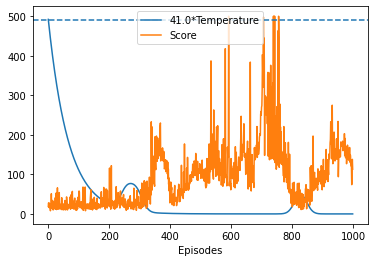

In [65]:
prof  = my_results.get_profile(45)
score = my_results.get_score(45)
best_max_temp = prof[0]

scale = 500//best_max_temp # 500//9 = 55
plt.plot(scale*prof, label = str(scale)+'*Temperature')
plt.plot(np.array(score), label = 'Score')
plt.axhline(490, linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("")
plt.legend()
plt.show()

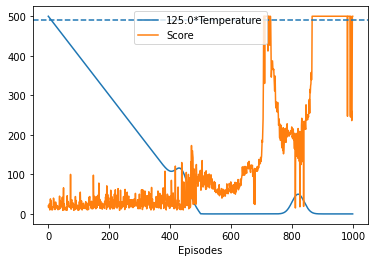

In [66]:
prof  = my_results.get_profile(10)
score = my_results.get_score(10)
best_max_temp = prof[0]

scale = 500//best_max_temp # 500//9 = 55
plt.plot(scale*prof, label = str(scale)+'*Temperature')
plt.plot(np.array(score), label = 'Score')
plt.axhline(490, linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("")
plt.legend()
plt.show()

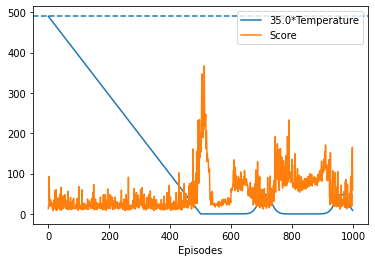

In [67]:
prof  = my_results.get_profile(25)
score = my_results.get_score(25)
best_max_temp = prof[0]

scale = 500//best_max_temp # 500//9 = 55
plt.plot(scale*prof, label = str(scale)+'*Temperature')
plt.plot(np.array(score), label = 'Score')
plt.axhline(490, linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("")
plt.legend()
plt.show()

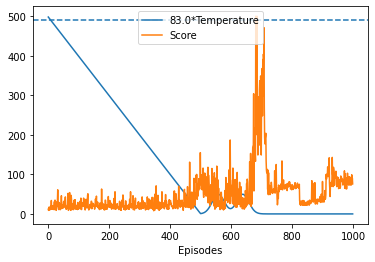

In [68]:
prof  = my_results.get_profile(9)
score = my_results.get_score(9)
best_max_temp = prof[0]

scale = 500//best_max_temp # 500//9 = 55
plt.plot(scale*prof, label = str(scale)+'*Temperature')
plt.plot(np.array(score), label = 'Score')
plt.axhline(490, linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("")
plt.legend()
plt.show()

### Training the best network

In [55]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

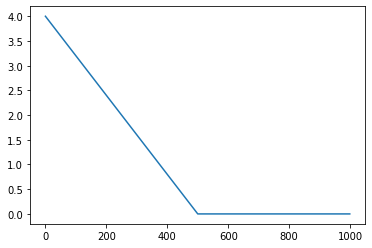

In [56]:
plt.plot(profile)

In [57]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(seed) # Set a random seed for the environment (reproducible results)
scores_list = []
# This is for creating the output video in Colab, not required outside Colab
# env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

for episode_num, tau in enumerate(tqdm(profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
        update_step(policy_net, target_net, replay_mem, best_gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
#       env.render()
      
      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % best_target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    scores_list.append(score)
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

# env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 21 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 23 - Temperature: 3.992
EPISODE: 3 - FINAL SCORE: 17 - Temperature: 3.984
EPISODE: 4 - FINAL SCORE: 15 - Temperature: 3.976
EPISODE: 5 - FINAL SCORE: 12 - Temperature: 3.968
Updating target network...
EPISODE: 6 - FINAL SCORE: 13 - Temperature: 3.96
EPISODE: 7 - FINAL SCORE: 22 - Temperature: 3.952
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 3.944
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 3.936
EPISODE: 10 - FINAL SCORE: 14 - Temperature: 3.928
Updating target network...
EPISODE: 11 - FINAL SCORE: 13 - Temperature: 3.92
EPISODE: 12 - FINAL SCORE: 19 - Temperature: 3.912
EPISODE: 13 - FINAL SCORE: 32 - Temperature: 3.904
EPISODE: 14 - FINAL SCORE: 27 - Temperature: 3.896
EPISODE: 15 - FINAL SCORE: 17 - Temperature: 3.888
Updating target network...
EPISODE: 16 - FINAL SCORE: 57 - Temperature: 3.88
EPISODE: 17 - FINAL SCORE: 31 - Temperature: 3.872
EPISODE: 18 - FINAL SCORE: 31 - Tempera

EPISODE: 145 - FINAL SCORE: 25 - Temperature: 2.848
Updating target network...
EPISODE: 146 - FINAL SCORE: 16 - Temperature: 2.84
EPISODE: 147 - FINAL SCORE: 21 - Temperature: 2.832
EPISODE: 148 - FINAL SCORE: 17 - Temperature: 2.824
EPISODE: 149 - FINAL SCORE: 18 - Temperature: 2.816
EPISODE: 150 - FINAL SCORE: 15 - Temperature: 2.808
Updating target network...
EPISODE: 151 - FINAL SCORE: 24 - Temperature: 2.8
EPISODE: 152 - FINAL SCORE: 70 - Temperature: 2.792
EPISODE: 153 - FINAL SCORE: 43 - Temperature: 2.784
EPISODE: 154 - FINAL SCORE: 29 - Temperature: 2.776
EPISODE: 155 - FINAL SCORE: 26 - Temperature: 2.768
Updating target network...
EPISODE: 156 - FINAL SCORE: 56 - Temperature: 2.76
EPISODE: 157 - FINAL SCORE: 24 - Temperature: 2.752
EPISODE: 158 - FINAL SCORE: 15 - Temperature: 2.7439999999999998
EPISODE: 159 - FINAL SCORE: 26 - Temperature: 2.7359999999999998
EPISODE: 160 - FINAL SCORE: 22 - Temperature: 2.7279999999999998
Updating target network...
EPISODE: 161 - FINAL SCOR

EPISODE: 279 - FINAL SCORE: 13 - Temperature: 1.7759999999999998
EPISODE: 280 - FINAL SCORE: 63 - Temperature: 1.7679999999999998
Updating target network...
EPISODE: 281 - FINAL SCORE: 18 - Temperature: 1.7599999999999998
EPISODE: 282 - FINAL SCORE: 39 - Temperature: 1.7519999999999998
EPISODE: 283 - FINAL SCORE: 34 - Temperature: 1.7439999999999998
EPISODE: 284 - FINAL SCORE: 98 - Temperature: 1.7359999999999998
EPISODE: 285 - FINAL SCORE: 14 - Temperature: 1.7279999999999998
Updating target network...
EPISODE: 286 - FINAL SCORE: 29 - Temperature: 1.7199999999999998
EPISODE: 287 - FINAL SCORE: 19 - Temperature: 1.7119999999999997
EPISODE: 288 - FINAL SCORE: 52 - Temperature: 1.7039999999999997
EPISODE: 289 - FINAL SCORE: 19 - Temperature: 1.6959999999999997
EPISODE: 290 - FINAL SCORE: 21 - Temperature: 1.6880000000000002
Updating target network...
EPISODE: 291 - FINAL SCORE: 19 - Temperature: 1.6800000000000002
EPISODE: 292 - FINAL SCORE: 22 - Temperature: 1.6720000000000002
EPISODE: 

Updating target network...
EPISODE: 406 - FINAL SCORE: 29 - Temperature: 0.7599999999999998
EPISODE: 407 - FINAL SCORE: 78 - Temperature: 0.7519999999999998
EPISODE: 408 - FINAL SCORE: 22 - Temperature: 0.7439999999999998
EPISODE: 409 - FINAL SCORE: 44 - Temperature: 0.7359999999999998
EPISODE: 410 - FINAL SCORE: 14 - Temperature: 0.7279999999999998
Updating target network...
EPISODE: 411 - FINAL SCORE: 41 - Temperature: 0.7199999999999998
EPISODE: 412 - FINAL SCORE: 18 - Temperature: 0.7119999999999997
EPISODE: 413 - FINAL SCORE: 18 - Temperature: 0.7039999999999997
EPISODE: 414 - FINAL SCORE: 33 - Temperature: 0.6959999999999997
EPISODE: 415 - FINAL SCORE: 19 - Temperature: 0.6879999999999997
Updating target network...
EPISODE: 416 - FINAL SCORE: 29 - Temperature: 0.6799999999999997
EPISODE: 417 - FINAL SCORE: 35 - Temperature: 0.6719999999999997
EPISODE: 418 - FINAL SCORE: 30 - Temperature: 0.6640000000000001
EPISODE: 419 - FINAL SCORE: 34 - Temperature: 0.6560000000000001
EPISODE: 

EPISODE: 530 - FINAL SCORE: 39 - Temperature: 1e-05
Updating target network...
EPISODE: 531 - FINAL SCORE: 34 - Temperature: 1e-05
EPISODE: 532 - FINAL SCORE: 20 - Temperature: 1e-05
EPISODE: 533 - FINAL SCORE: 28 - Temperature: 1e-05
EPISODE: 534 - FINAL SCORE: 24 - Temperature: 1e-05
EPISODE: 535 - FINAL SCORE: 22 - Temperature: 1e-05
Updating target network...
EPISODE: 536 - FINAL SCORE: 25 - Temperature: 1e-05
EPISODE: 537 - FINAL SCORE: 19 - Temperature: 1e-05
EPISODE: 538 - FINAL SCORE: 17 - Temperature: 1e-05
EPISODE: 539 - FINAL SCORE: 23 - Temperature: 1e-05
EPISODE: 540 - FINAL SCORE: 17 - Temperature: 1e-05
Updating target network...
EPISODE: 541 - FINAL SCORE: 21 - Temperature: 1e-05
EPISODE: 542 - FINAL SCORE: 23 - Temperature: 1e-05
EPISODE: 543 - FINAL SCORE: 22 - Temperature: 1e-05
EPISODE: 544 - FINAL SCORE: 16 - Temperature: 1e-05
EPISODE: 545 - FINAL SCORE: 19 - Temperature: 1e-05
Updating target network...
EPISODE: 546 - FINAL SCORE: 19 - Temperature: 1e-05
EPISODE:

EPISODE: 673 - FINAL SCORE: 28 - Temperature: 1e-05
EPISODE: 674 - FINAL SCORE: 33 - Temperature: 1e-05
EPISODE: 675 - FINAL SCORE: 31 - Temperature: 1e-05
Updating target network...
EPISODE: 676 - FINAL SCORE: 17 - Temperature: 1e-05
EPISODE: 677 - FINAL SCORE: 35 - Temperature: 1e-05
EPISODE: 678 - FINAL SCORE: 28 - Temperature: 1e-05
EPISODE: 679 - FINAL SCORE: 21 - Temperature: 1e-05
EPISODE: 680 - FINAL SCORE: 34 - Temperature: 1e-05
Updating target network...
EPISODE: 681 - FINAL SCORE: 35 - Temperature: 1e-05
EPISODE: 682 - FINAL SCORE: 52 - Temperature: 1e-05
EPISODE: 683 - FINAL SCORE: 59 - Temperature: 1e-05
EPISODE: 684 - FINAL SCORE: 38 - Temperature: 1e-05
EPISODE: 685 - FINAL SCORE: 44 - Temperature: 1e-05
Updating target network...
EPISODE: 686 - FINAL SCORE: 30 - Temperature: 1e-05
EPISODE: 687 - FINAL SCORE: 46 - Temperature: 1e-05
EPISODE: 688 - FINAL SCORE: 61 - Temperature: 1e-05
EPISODE: 689 - FINAL SCORE: 46 - Temperature: 1e-05
EPISODE: 690 - FINAL SCORE: 28 - Te

EPISODE: 815 - FINAL SCORE: 247 - Temperature: 1e-05
Updating target network...
EPISODE: 816 - FINAL SCORE: 223 - Temperature: 1e-05
EPISODE: 817 - FINAL SCORE: 335 - Temperature: 1e-05
EPISODE: 818 - FINAL SCORE: 176 - Temperature: 1e-05
EPISODE: 819 - FINAL SCORE: 159 - Temperature: 1e-05
EPISODE: 820 - FINAL SCORE: 233 - Temperature: 1e-05
Updating target network...
EPISODE: 821 - FINAL SCORE: 244 - Temperature: 1e-05
EPISODE: 822 - FINAL SCORE: 264 - Temperature: 1e-05
EPISODE: 823 - FINAL SCORE: 254 - Temperature: 1e-05
EPISODE: 824 - FINAL SCORE: 198 - Temperature: 1e-05
EPISODE: 825 - FINAL SCORE: 154 - Temperature: 1e-05
Updating target network...
EPISODE: 826 - FINAL SCORE: 270 - Temperature: 1e-05
EPISODE: 827 - FINAL SCORE: 202 - Temperature: 1e-05
EPISODE: 828 - FINAL SCORE: 206 - Temperature: 1e-05
EPISODE: 829 - FINAL SCORE: 174 - Temperature: 1e-05
EPISODE: 830 - FINAL SCORE: 228 - Temperature: 1e-05
Updating target network...
EPISODE: 831 - FINAL SCORE: 137 - Temperatur

Updating target network...
EPISODE: 956 - FINAL SCORE: 399 - Temperature: 1e-05
EPISODE: 957 - FINAL SCORE: 280 - Temperature: 1e-05
EPISODE: 958 - FINAL SCORE: 242 - Temperature: 1e-05
EPISODE: 959 - FINAL SCORE: 263 - Temperature: 1e-05
EPISODE: 960 - FINAL SCORE: 263 - Temperature: 1e-05
Updating target network...
EPISODE: 961 - FINAL SCORE: 476 - Temperature: 1e-05
EPISODE: 962 - FINAL SCORE: 500 - Temperature: 1e-05
EPISODE: 963 - FINAL SCORE: 398 - Temperature: 1e-05
EPISODE: 964 - FINAL SCORE: 500 - Temperature: 1e-05
EPISODE: 965 - FINAL SCORE: 470 - Temperature: 1e-05
Updating target network...
EPISODE: 966 - FINAL SCORE: 471 - Temperature: 1e-05
EPISODE: 967 - FINAL SCORE: 500 - Temperature: 1e-05
EPISODE: 968 - FINAL SCORE: 418 - Temperature: 1e-05
EPISODE: 969 - FINAL SCORE: 484 - Temperature: 1e-05
EPISODE: 970 - FINAL SCORE: 500 - Temperature: 1e-05
Updating target network...
EPISODE: 971 - FINAL SCORE: 500 - Temperature: 1e-05
EPISODE: 972 - FINAL SCORE: 500 - Temperatur

# Final test

In [58]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(seed) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, folder = 'first' , video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [75]:
torch.save(policy_net.state_dict(), 'Cartpole_trained')

In [ ]:
# Display the videos, not required outside Colab
# show_videos()